In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import sem
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel, ttest_ind

In [2]:
import rpy2

In [3]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# import R's "base" package
utils = importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

packnames = ['lme4', 'optimx', 'pbkrtest', 'lmerTest',
             'ggplot2', 'dplyr', 'sjPlot', 'car']

# if there is no package then install it
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [4]:
%load_ext rpy2.ipython

# import R's "base" package
lme4 = importr('lme4')
optimx = importr('optimx')
pbkrtest = importr('pbkrtest')
lmerTest = importr('lmerTest')
ggplot = importr('ggplot2')
dplyr = importr('dplyr')
sjp = importr('sjPlot')
sjmisc = importr('sjmisc')
car = importr('car')
lattice = importr('lattice')

In [5]:
home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
out_dir = home_dir + 'figures/figures_all/'
R_out_dir = home_dir + 'R_analysis_data/'

In [6]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()

In [7]:
condition = (np.array(data_puzzle_level.condition)-0.5)*2 # recode it to 1 and -1
subject = np.array(data_puzzle_level.subjects)
puzzleID = np.array(data_puzzle_level.puzzleID)

mas = np.array(data_puzzle_level.mas)
num_loss = np.array(data_puzzle_level.mas) - np.array(data_puzzle_level.numCities)

numUndo = np.array(data_puzzle_level.numUNDO)
numFullUndo = np.array(data_puzzle_level.numFullUndo)
# numFullUndo = np.sign(numFullUndo)

dat = pd.DataFrame({'condition':condition,'subject':subject, 'puzzleID':puzzleID,
                    'mas':mas, 'num_loss':num_loss,
                    'numUndo':numUndo, 'numFullUndo':numFullUndo, 
                    'numFullUndo_factor':numFullUndo,
                    'numUndo_center':numUndo,'numFullUndo_center':numFullUndo,
                    'numUndo_center0':numUndo,'numFullUndo_center0':numFullUndo})


# fix bug
dat.loc[dat[dat.num_loss == -1].index,'mas'] = 9
num_loss = np.array(dat.mas) - np.array(data_puzzle_level.numCities)
dat.num_loss = num_loss

In [8]:
# center number of undo in undo condition
for si in np.unique(dat.subject):
    index = np.intersect1d(dat[dat['condition']==1].index, dat[dat['subject']==si].index)
    dat.loc[index,'numFullUndo_center'] = dat.loc[index,'numFullUndo'] - dat.loc[index,'numFullUndo'].mean()
    dat.loc[index,'numUndo_center'] = dat.loc[index,'numUndo'] - dat.loc[index,'numUndo'].mean()


In [9]:
# Assumption here: there is no effect of not undoing, but centralize for others. 
for si in np.unique(dat.subject):
    index = np.intersect1d(dat[dat['condition']==1].index,dat[dat['subject']==si].index)
    index = np.intersect1d(dat[dat['numFullUndo']!=0].index, index)
    dat.loc[index,'numFullUndo_center0'] = dat.loc[index,'numFullUndo'] - dat.loc[index,'numFullUndo'].mean()
    dat.loc[index,'numUndo_center0'] = dat.loc[index,'numUndo'] - dat.loc[index,'numUndo'].mean()

In [10]:
dat.loc[dat.numFullUndo_factor ==1,'numFullUndo_factor'] = 1
dat.loc[dat.numFullUndo_factor >=2,'numFullUndo_factor'] = 2

# basic statistics plot

In [44]:
# check undo and condition correlation
pearsonr(dat['numFullUndo'], dat['condition'])

pearsonr(dat['numFullUndo_center'], dat['condition'])

(0.3191622974793546, 4.856109648837779e-219)

## number of undo histogram

<IPython.core.display.Javascript object>


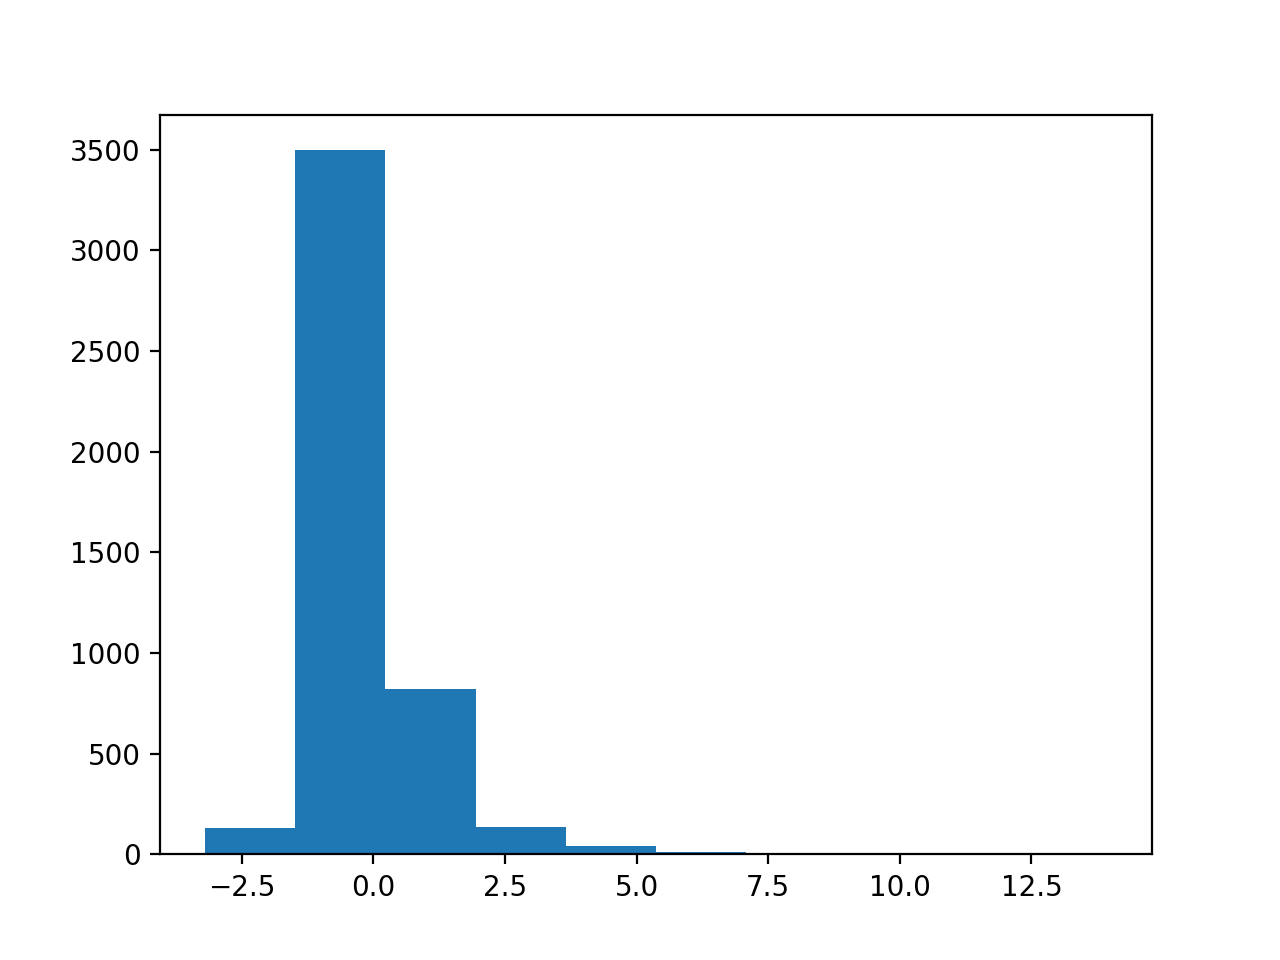

(array([1.310e+02, 3.496e+03, 8.230e+02, 1.340e+02, 4.200e+01, 1.200e+01,
        3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([-3.19565217, -1.4826087 ,  0.23043478,  1.94347826,  3.65652174,
         5.36956522,  7.0826087 ,  8.79565217, 10.50869565, 12.22173913,
        13.93478261]),
 <BarContainer object of 10 artists>)

In [84]:
%matplotlib notebook

plt.hist(dat["numFullUndo_center"][index])

## missed points histogram

### all raw data

<IPython.core.display.Javascript object>


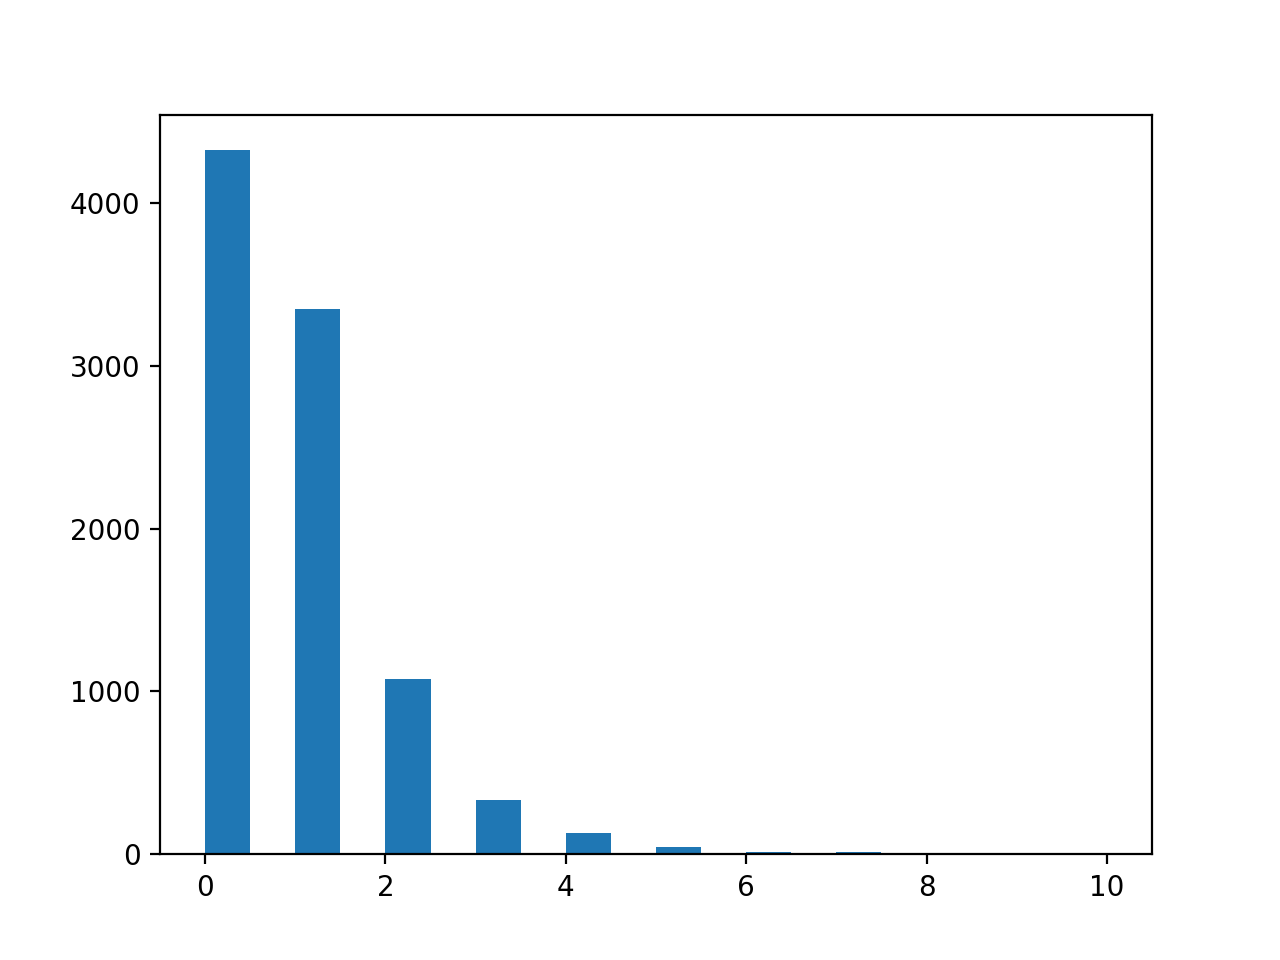

(array([4.321e+03, 0.000e+00, 3.348e+03, 0.000e+00, 1.074e+03, 0.000e+00,
        3.310e+02, 0.000e+00, 1.290e+02, 0.000e+00, 4.700e+01, 0.000e+00,
        1.400e+01, 0.000e+00, 1.700e+01, 0.000e+00, 9.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

In [11]:
%matplotlib notebook

plt.hist(num_loss,20)

### average within subject

<IPython.core.display.Javascript object>


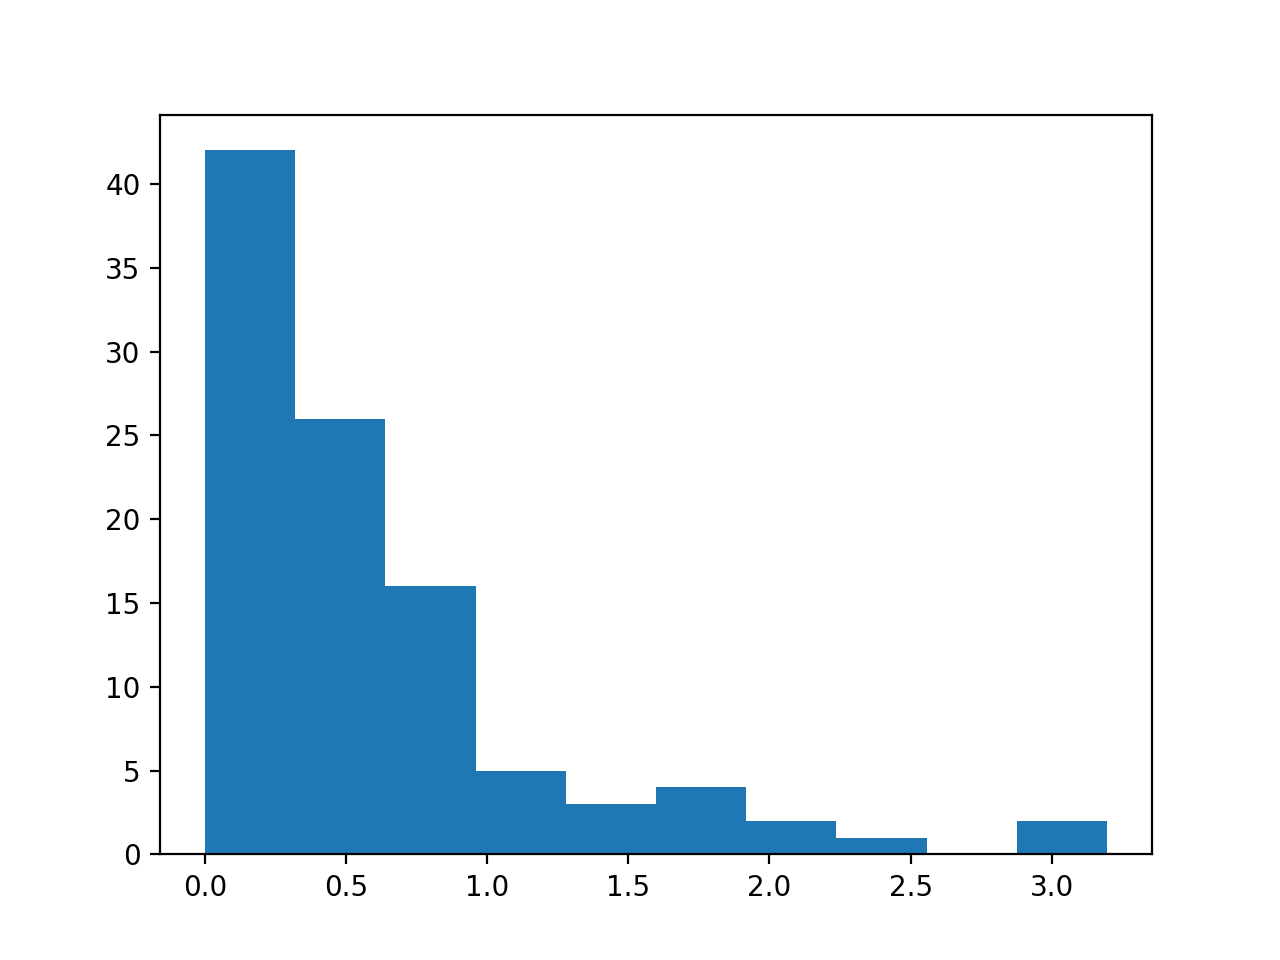

0.5837279380111925


In [14]:
%matplotlib notebook

centers = []
for si in np.unique(dat.subject):
    index = np.intersect1d(dat[dat['condition']==1].index,dat[dat['subject']==si].index)
    centers.append(dat['numFullUndo'][index].mean()) # average within each subject

plt.hist(centers)
print(np.mean(centers))

## missed points - number of undo scatter plot

<IPython.core.display.Javascript object>


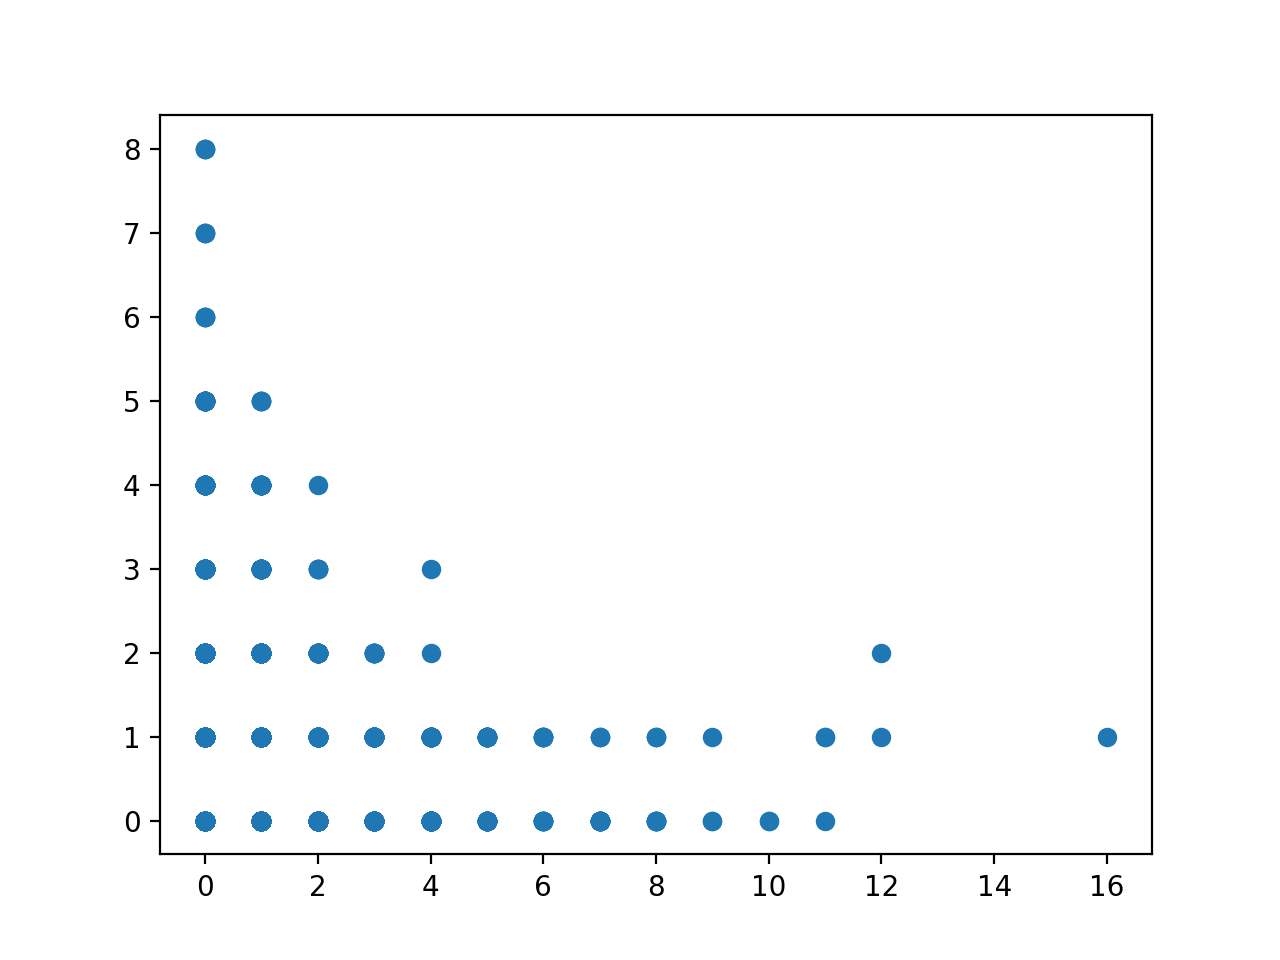

In [82]:
%matplotlib notebook

index = dat[dat['condition']==1].index
plt.scatter(dat.loc[index,"numFullUndo"], num_loss[index])

# GLMM with numFullUndo_center

## R models

In [11]:
%%R -i dat

# dat$numFullUndo <- factor(dat$numFullUndo)
dat$numFullUndo_factor <- factor(dat$numFullUndo_factor)
dat$subject <- factor(dat$subject)
# dat$condition <- factor(dat$condition)
dat$puzzleID <- factor(dat$puzzleID)

In [64]:
%%R

model0 = glmer(num_loss ~ condition + numFullUndo_center + (1|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

In [65]:
%%R
model1 = glmer(num_loss ~ condition + numFullUndo_center + (1|puzzleID) + (1+numFullUndo_center|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



In [68]:
%%R

model.matrix(model1)

     (Intercept) condition numFullUndo_center
0              1         1         0.21739130
1              1         1         1.21739130
2              1         1        -0.78260870
3              1         1        -0.78260870
4              1         1        -0.78260870
5              1         1        -0.78260870
6              1         1         1.21739130
7              1         1         0.21739130
8              1         1        -0.78260870
9              1         1         1.21739130
10             1         1        -0.78260870
11             1         1        -0.78260870
12             1         1        -0.78260870
13             1         1        -0.78260870
14             1         1         0.21739130
15             1         1         1.21739130
16             1         1        -0.78260870
17             1         1         2.21739130
18             1         1        -0.78260870
19             1         1        -0.78260870
20             1         1        

177            1         1        -0.43478261
178            1         1        -0.43478261
179            1         1         1.56521739
180            1         1        -0.43478261
181            1         1        -0.43478261
182            1         1         0.56521739
183            1         1        -1.43478261
184            1        -1         0.00000000
185            1        -1         0.00000000
186            1        -1         0.00000000
187            1        -1         0.00000000
188            1        -1         0.00000000
189            1        -1         0.00000000
190            1        -1         0.00000000
191            1        -1         0.00000000
192            1        -1         0.00000000
193            1        -1         0.00000000
194            1        -1         0.00000000
195            1        -1         0.00000000
196            1        -1         0.00000000
197            1        -1         0.00000000
198            1        -1        

355            1         1         0.60869565
356            1         1        -1.39130435
357            1         1         0.60869565
358            1         1        -1.39130435
359            1         1        -1.39130435
360            1         1        -1.39130435
361            1         1        -1.39130435
362            1         1        -1.39130435
363            1         1        -0.39130435
364            1         1        -1.39130435
365            1         1        -1.39130435
366            1         1        -1.39130435
367            1         1        -1.39130435
368            1        -1         0.00000000
369            1        -1         0.00000000
370            1        -1         0.00000000
371            1        -1         0.00000000
372            1        -1         0.00000000
373            1        -1         0.00000000
374            1        -1         0.00000000
375            1        -1         0.00000000
376            1        -1        

533            1         1        -0.06521739
534            1         1        -0.06521739
535            1         1        -0.06521739
536            1         1        -0.06521739
537            1         1         0.93478261
538            1         1        -0.06521739
539            1         1        -0.06521739
540            1         1        -0.06521739
541            1         1        -0.06521739
542            1         1        -0.06521739
543            1         1        -0.06521739
544            1         1        -0.06521739
545            1         1        -0.06521739
546            1         1        -0.06521739
547            1         1        -0.06521739
548            1         1        -0.06521739
549            1         1        -0.06521739
550            1         1        -0.06521739
551            1         1        -0.06521739
552            1        -1         0.00000000
553            1        -1         0.00000000
554            1        -1        

711            1         1        -0.34782609
712            1         1        -0.34782609
713            1        -1         0.00000000
714            1        -1         0.00000000
715            1        -1         0.00000000
716            1        -1         0.00000000
717            1        -1         0.00000000
718            1        -1         0.00000000
719            1        -1         0.00000000
720            1        -1         0.00000000
721            1        -1         0.00000000
722            1        -1         0.00000000
723            1        -1         0.00000000
724            1        -1         0.00000000
725            1        -1         0.00000000
726            1        -1         0.00000000
727            1        -1         0.00000000
728            1        -1         0.00000000
729            1        -1         0.00000000
730            1        -1         0.00000000
731            1        -1         0.00000000
732            1        -1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



        -0.13043478
1006           1         1        -0.13043478
1007           1         1        -0.13043478
1008           1         1        -0.13043478
1009           1         1        -0.13043478
1010           1         1        -0.13043478
1011           1         1        -0.13043478
1012           1        -1         0.00000000
1013           1        -1         0.00000000
1014           1        -1         0.00000000
1015           1        -1         0.00000000
1016           1        -1         0.00000000
1017           1        -1         0.00000000
1018           1        -1         0.00000000
1019           1        -1         0.00000000
1020           1        -1         0.00000000
1021           1        -1         0.00000000
1022           1        -1         0.00000000
1023           1        -1         0.00000000
1024           1        -1         0.00000000
1025           1        -1         0.00000000
1026           1        -1         0.00000000
1027          

1183           1         1        -0.02173913
1184           1         1        -0.02173913
1185           1         1        -0.02173913
1186           1         1        -0.02173913
1187           1         1        -0.02173913
1188           1         1        -0.02173913
1189           1         1        -0.02173913
1190           1         1        -0.02173913
1191           1         1        -0.02173913
1192           1         1        -0.02173913
1193           1         1        -0.02173913
1194           1         1        -0.02173913
1195           1         1        -0.02173913
1196           1         1        -0.30434783
1197           1         1         1.69565217
1198           1         1        -0.30434783
1199           1         1        -0.30434783
1200           1         1        -0.30434783
1201           1         1        -0.30434783
1202           1         1        -0.30434783
1203           1         1        -0.30434783
1204           1         1        

1361           1         1        -0.15217391
1362           1         1        -1.15217391
1363           1         1         1.84782609
1364           1         1        -1.15217391
1365           1         1        -0.15217391
1366           1         1         1.84782609
1367           1         1        -1.15217391
1368           1         1        -1.15217391
1369           1         1        -0.15217391
1370           1         1        -1.15217391
1371           1         1        -1.15217391
1372           1         1        -1.15217391
1373           1         1         1.84782609
1374           1         1        -1.15217391
1375           1         1        -0.15217391
1376           1         1        -0.15217391
1377           1         1        -1.15217391
1378           1         1         1.84782609
1379           1         1        -1.15217391
1380           1        -1         0.00000000
1381           1        -1         0.00000000
1382           1        -1        

1539           1        -1         0.00000000
1540           1        -1         0.00000000
1541           1         1        -0.23913043
1542           1         1        -0.23913043
1543           1         1         0.76086957
1544           1         1         0.76086957
1545           1         1        -0.23913043
1546           1         1         0.76086957
1547           1         1        -0.23913043
1548           1         1        -0.23913043
1549           1         1        -0.23913043
1550           1         1        -0.23913043
1551           1         1        -0.23913043
1552           1         1         0.76086957
1553           1         1         2.76086957
1554           1         1        -0.23913043
1555           1         1         0.76086957
1556           1         1         1.76086957
1557           1         1        -0.23913043
1558           1         1        -0.23913043
1559           1         1        -0.23913043
1560           1         1        

1717           1        -1         0.00000000
1718           1        -1         0.00000000
1719           1        -1         0.00000000
1720           1        -1         0.00000000
1721           1        -1         0.00000000
1722           1        -1         0.00000000
1723           1        -1         0.00000000
1724           1        -1         0.00000000
1725           1         1        -0.78260870
1726           1         1         0.21739130
1727           1         1        -0.78260870
1728           1         1        -0.78260870
1729           1         1        -0.78260870
1730           1         1        -0.78260870
1731           1         1         0.21739130
1732           1         1         0.21739130
1733           1         1        -0.78260870
1734           1         1        -0.78260870
1735           1         1        -0.78260870
1736           1         1         0.21739130
1737           1         1        -0.78260870
1738           1         1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




2110           1         1        -0.36956522
2111           1         1         0.63043478
2112           1         1         1.63043478
2113           1         1        -0.36956522
2114           1         1        -0.36956522
2115           1         1        -0.36956522
2116           1         1         2.71739130
2117           1         1        -1.28260870
2118           1         1        -1.28260870
2119           1         1        -0.28260870
2120           1         1         0.71739130
2121           1         1         0.71739130
2122           1         1        -1.28260870
2123           1         1         0.71739130
2124           1         1        -0.28260870
2125           1         1        -1.28260870
2126           1         1        -0.28260870
2127           1         1        -1.28260870
2128           1         1         0.71739130
2129           1         1        -1.28260870
2130           1         1        -1.28260870
2131           1         1       

2288           1        -1         0.00000000
2289           1        -1         0.00000000
2290           1        -1         0.00000000
2291           1        -1         0.00000000
2292           1        -1         0.00000000
2293           1        -1         0.00000000
2294           1        -1         0.00000000
2295           1        -1         0.00000000
2296           1        -1         0.00000000
2297           1        -1         0.00000000
2298           1        -1         0.00000000
2299           1        -1         0.00000000
2300           1         1         0.00000000
2301           1         1         0.00000000
2302           1         1         0.00000000
2303           1         1         0.00000000
2304           1         1         0.00000000
2305           1         1         0.00000000
2306           1         1         0.00000000
2307           1         1         0.00000000
2308           1         1         0.00000000
2309           1         1        

2466           1        -1         0.00000000
2467           1        -1         0.00000000
2468           1        -1         0.00000000
2469           1        -1         0.00000000
2470           1        -1         0.00000000
2471           1        -1         0.00000000
2472           1        -1         0.00000000
2473           1        -1         0.00000000
2474           1        -1         0.00000000
2475           1        -1         0.00000000
2476           1        -1         0.00000000
2477           1        -1         0.00000000
2478           1        -1         0.00000000
2479           1        -1         0.00000000
2480           1        -1         0.00000000
2481           1        -1         0.00000000
2482           1        -1         0.00000000
2483           1        -1         0.00000000
2484           1        -1         0.00000000
2485           1        -1         0.00000000
2486           1        -1         0.00000000
2487           1        -1        

2644           1        -1         0.00000000
2645           1         1        -0.06521739
2646           1         1        -0.06521739
2647           1         1        -0.06521739
2648           1         1        -0.06521739
2649           1         1        -0.06521739
2650           1         1        -0.06521739
2651           1         1        -0.06521739
2652           1         1        -0.06521739
2653           1         1        -0.06521739
2654           1         1        -0.06521739
2655           1         1        -0.06521739
2656           1         1        -0.06521739
2657           1         1        -0.06521739
2658           1         1        -0.06521739
2659           1         1        -0.06521739
2660           1         1        -0.06521739
2661           1         1        -0.06521739
2662           1         1        -0.06521739
2663           1         1        -0.06521739
2664           1         1        -0.06521739
2665           1         1        

2822           1         1        -0.08695652
2823           1         1        -0.08695652
2824           1         1         0.91304348
2825           1         1        -0.08695652
2826           1         1        -0.08695652
2827           1         1        -0.08695652
2828           1         1        -0.08695652
2829           1        -1         0.00000000
2830           1        -1         0.00000000
2831           1        -1         0.00000000
2832           1        -1         0.00000000
2833           1        -1         0.00000000
2834           1        -1         0.00000000
2835           1        -1         0.00000000
2836           1        -1         0.00000000
2837           1        -1         0.00000000
2838           1        -1         0.00000000
2839           1        -1         0.00000000
2840           1        -1         0.00000000
2841           1        -1         0.00000000
2842           1        -1         0.00000000
2843           1        -1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



        -0.08695652
3210           1         1         0.91304348
3211           1         1        -0.08695652
3212           1         1        -0.08695652
3213           1         1        -0.08695652
3214           1         1        -0.08695652
3215           1         1         0.91304348
3216           1         1        -0.08695652
3217           1         1        -0.08695652
3218           1         1        -0.08695652
3219           1         1        -0.08695652
3220           1         1        -0.52173913
3221           1         1         0.47826087
3222           1         1         0.47826087
3223           1         1        -0.52173913
3224           1         1         0.47826087
3225           1         1         0.47826087
3226           1         1         0.47826087
3227           1         1        -0.52173913
3228           1         1         0.47826087
3229           1         1         0.47826087
3230           1         1        -0.52173913
3231          

3387           1         1        -0.13043478
3388           1         1        -0.13043478
3389           1         1        -0.13043478
3390           1         1        -0.13043478
3391           1         1        -0.13043478
3392           1         1        -0.13043478
3393           1         1        -0.13043478
3394           1         1        -0.13043478
3395           1         1        -0.13043478
3396           1         1        -0.13043478
3397           1         1        -0.13043478
3398           1         1        -0.13043478
3399           1         1        -0.13043478
3400           1         1        -0.13043478
3401           1         1        -0.13043478
3402           1         1        -0.13043478
3403           1         1        -0.13043478
3404           1         1        -0.34782609
3405           1         1        -0.34782609
3406           1         1         1.65217391
3407           1         1        -0.34782609
3408           1         1        

3565           1         1         0.36956522
3566           1         1        -0.63043478
3567           1         1         1.36956522
3568           1         1        -0.63043478
3569           1         1        -0.63043478
3570           1         1        -0.63043478
3571           1         1         0.36956522
3572           1         1        -0.63043478
3573           1         1        -0.63043478
3574           1         1        -0.63043478
3575           1         1         1.36956522
3576           1         1         0.36956522
3577           1         1         1.36956522
3578           1         1        -0.63043478
3579           1         1        -0.63043478
3580           1         1         0.36956522
3581           1         1         0.36956522
3582           1         1         0.36956522
3583           1         1         0.36956522
3584           1         1        -0.63043478
3585           1         1         0.36956522
3586           1         1        

3749           1        -1         0.00000000
3750           1        -1         0.00000000
3751           1        -1         0.00000000
3752           1        -1         0.00000000
3753           1        -1         0.00000000
3754           1        -1         0.00000000
3755           1        -1         0.00000000
3756           1        -1         0.00000000
3757           1        -1         0.00000000
3758           1        -1         0.00000000
3759           1        -1         0.00000000
3760           1        -1         0.00000000
3761           1        -1         0.00000000
3762           1        -1         0.00000000
3763           1        -1         0.00000000
3764           1        -1         0.00000000
3765           1        -1         0.00000000
3766           1        -1         0.00000000
3767           1        -1         0.00000000
3768           1        -1         0.00000000
3769           1        -1         0.00000000
3770           1        -1        

3954           1        -1         0.00000000
3955           1        -1         0.00000000
3956           1         1        -0.89130435
3957           1         1        -0.89130435
3958           1         1        -0.89130435
3959           1         1        -0.89130435
3960           1         1        -0.89130435
3961           1         1        -0.89130435
3962           1         1        -0.89130435
3963           1         1        -0.89130435
3964           1         1        -0.89130435
3965           1         1        -0.89130435
3966           1         1        -0.89130435
3967           1         1        -0.89130435
3968           1         1        -0.89130435
3969           1         1        -0.89130435
3970           1         1        -0.89130435
3971           1         1        -0.89130435
3972           1         1        -0.89130435
3973           1         1        -0.89130435
3974           1         1        -0.89130435
3975           1         1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



         1        -0.04347826
4537           1         1        -0.04347826
4538           1         1        -0.04347826
4539           1         1        -0.04347826
4540           1         1        -0.04347826
4541           1         1        -0.04347826
4542           1         1        -0.04347826
4543           1         1        -0.04347826
4544           1         1        -0.04347826
4545           1         1        -0.04347826
4546           1         1        -0.04347826
4547           1         1         0.95652174
4548           1         1        -0.04347826
4549           1         1        -0.04347826
4550           1         1        -0.04347826
4551           1         1        -0.04347826
4552           1         1        -0.04347826
4553           1         1        -0.04347826
4554           1         1        -0.04347826
4555           1         1        -0.04347826
4556           1         1        -0.04347826
4557           1         1        -0.04347826
4558

4751           1        -1         0.00000000
4752           1        -1         0.00000000
4753           1        -1         0.00000000
4754           1        -1         0.00000000
4755           1        -1         0.00000000
4756           1        -1         0.00000000
4757           1        -1         0.00000000
4758           1        -1         0.00000000
4759           1        -1         0.00000000
4760           1        -1         0.00000000
4761           1         1        -0.10869565
4762           1         1        -0.10869565
4763           1         1        -0.10869565
4764           1         1        -0.10869565
4765           1         1        -0.10869565
4766           1         1        -0.10869565
4767           1         1        -0.10869565
4768           1         1        -0.10869565
4769           1         1        -0.10869565
4770           1         1        -0.10869565
4771           1         1        -0.10869565
4772           1         1        

5112           1        -1         0.00000000
5113           1        -1         0.00000000
5114           1        -1         0.00000000
5115           1        -1         0.00000000
5116           1        -1         0.00000000
5117           1        -1         0.00000000
5118           1        -1         0.00000000
5119           1        -1         0.00000000
5120           1        -1         0.00000000
5121           1        -1         0.00000000           1         1         0.80434783
5147           1         1        -3.19565217
5148           1         1         2.80434783
5149           1         1         1.80434783
5150           1         1        -3.19565217
5151           1         1         4.80434783
5152           1        -1         0.00000000
5153           1        -1         0.00000000
5154           1        -1         0.00000000
5155           1        -1         0.00000000
5156           1        -1         0.00000000
5157           1        -1         0.00

5339           1        -1         0.00000000
5340           1        -1         0.00000000
5341           1        -1         0.00000000
5342           1        -1         0.00000000
5343           1        -1         0.00000000
5344           1        -1         0.00000000
5345           1        -1         0.00000000
5346           1        -1         0.00000000
5347           1        -1         0.00000000
5348           1        -1         0.00000000
5349           1        -1         0.00000000
5350           1        -1         0.00000000
5351           1        -1         0.00000000
5352           1        -1         0.00000000
5353           1        -1         0.00000000
5354           1        -1         0.00000000
5355           1        -1         0.00000000
5356           1        -1         0.00000000
5357           1        -1         0.00000000
5358           1        -1         0.00000000
5359           1         1         0.65217391
5360           1         1        

5517           1        -1         0.00000000
5518           1        -1         0.00000000
5519           1        -1         0.00000000
5520           1        -1         0.00000000
5521           1        -1         0.00000000
5522           1        -1         0.00000000
5523           1        -1         0.00000000
5524           1        -1         0.00000000
5525           1        -1         0.00000000
5526           1        -1         0.00000000
5527           1        -1         0.00000000
5528           1        -1         0.00000000
5529           1        -1         0.00000000
5530           1        -1         0.00000000
5531           1        -1         0.00000000
5532           1        -1         0.00000000
5533           1        -1         0.00000000
5534           1        -1         0.00000000
5535           1        -1         0.00000000
5536           1        -1         0.00000000
5537           1        -1         0.00000000
5538           1        -1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



         1        -0.15217391
6073           1         1         2.84782609
6074           1         1        -1.15217391
6075           1         1         0.84782609
6076           1         1        -1.15217391
6077           1         1         2.84782609
6078           1         1        -1.15217391
6079           1         1         1.84782609
6080           1         1        -1.15217391
6081           1         1         1.84782609
6082           1         1        -1.15217391
6083           1         1        -0.15217391
6084           1         1        -2.15217391
6085           1         1         0.84782609
6086           1         1        -2.15217391
6087           1         1        -0.15217391
6088           1         1         3.84782609
6089           1         1        -2.15217391
6090           1         1        -2.15217391
6091           1         1         4.84782609
6092           1         1         0.84782609
6093           1         1         2.84782609
6094

6250           1        -1         0.00000000
6251           1        -1         0.00000000
6252           1        -1         0.00000000
6253           1        -1         0.00000000
6254           1        -1         0.00000000
6255           1        -1         0.00000000
6256           1        -1         0.00000000
6257           1        -1         0.00000000
6258           1        -1         0.00000000
6259           1        -1         0.00000000
6260           1        -1         0.00000000
6261           1        -1         0.00000000
6262           1        -1         0.00000000
6263           1        -1         0.00000000
6264           1        -1         0.00000000
6265           1        -1         0.00000000
6266           1        -1         0.00000000
6267           1        -1         0.00000000
6268           1        -1         0.00000000
6269           1        -1         0.00000000
6270           1        -1         0.00000000
6271           1        -1        

6428           1        -1         0.00000000
6429           1        -1         0.00000000
6430           1        -1         0.00000000
6431           1        -1         0.00000000
6432           1        -1         0.00000000
6433           1        -1         0.00000000
6434           1        -1         0.00000000
6435           1        -1         0.00000000
6436           1        -1         0.00000000
6437           1        -1         0.00000000
6438           1        -1         0.00000000
6439           1        -1         0.00000000
6440           1        -1         0.00000000
6441           1        -1         0.00000000
6442           1        -1         0.00000000
6443           1        -1         0.00000000
6444           1        -1         0.00000000
6445           1        -1         0.00000000
6446           1        -1         0.00000000
6447           1        -1         0.00000000
6448           1        -1         0.00000000
6449           1        -1        

6608           1         1        -0.58695652
6609           1         1        -0.58695652
6610           1         1        -0.58695652
6611           1         1        -0.58695652
6612           1         1        -0.58695652
6613           1         1        -0.58695652
6614           1         1        -0.58695652
6615           1         1         0.41304348
6616           1         1        -0.58695652
6617           1         1         0.41304348
6618           1         1        -0.58695652
6619           1         1        -0.58695652
6620           1         1        -0.58695652
6621           1         1        -0.58695652
6622           1         1        -0.58695652
6623           1         1        -0.58695652
6624           1         1        -0.06521739
6625           1         1        -0.06521739
6626           1         1        -0.06521739
6627           1         1        -0.06521739
6628           1         1        -0.06521739
6629           1         1        

6808           1         1        -0.34782609
6809           1         1        -0.34782609
6810           1         1         1.65217391
6811           1         1        -0.34782609
6812           1         1         0.65217391
6813           1         1        -0.34782609
6814           1         1        -0.34782609
6815           1         1         0.65217391
6816           1         1        -0.34782609
6817           1         1        -0.34782609
6818           1         1        -0.34782609
6819           1         1         0.65217391
6820           1         1         0.65217391
6821           1         1        -0.34782609
6822           1         1         0.65217391
6823           1         1         2.65217391
6824           1         1         0.65217391
6825           1         1         0.65217391
6826           1         1         0.65217391
6827           1         1         0.65217391
6828           1         1         1.65217391
6829           1         1        

7016           1         1        -0.84782609
7017           1         1        -0.84782609
7018           1         1         1.15217391
7019           1         1        -0.84782609
7020           1         1        -0.84782609
7021           1         1        -0.84782609
7022           1         1        -0.84782609
7023           1         1        -0.84782609
7024           1         1         0.15217391
7025           1         1        -0.84782609
7026           1         1        -0.84782609
7027           1         1         0.15217391
7028           1         1        -0.84782609
7029           1         1         3.15217391
7030           1         1        -0.84782609
7031           1         1        -0.84782609
7032           1         1         0.15217391
7033           1         1         0.15217391
7034           1         1        -0.84782609
7035           1         1        -0.84782609
7036           1         1        -0.84782609
7037           1         1        

7230           1        -1         0.00000000
7231           1        -1         0.00000000
7232           1        -1         0.00000000
7233           1        -1         0.00000000
7234           1        -1         0.00000000
7235           1        -1         0.00000000
7236           1        -1         0.00000000
7237           1        -1         0.00000000
7238           1        -1         0.00000000
7239           1        -1         0.00000000
7240           1        -1         0.00000000
7241           1        -1         0.00000000
7242           1        -1         0.00000000
7243           1        -1         0.00000000
7244           1        -1         0.00000000
7245           1         1        -0.17391304
7246           1         1        -0.17391304
7247           1         1        -0.17391304
7248           1         1        -0.17391304
7249           1         1         0.82608696
7250           1         1        -0.17391304
7251           1         1        

7452           1         1         0.47826087
7453           1         1         0.47826087
7454           1         1         0.47826087
7455           1         1        -0.52173913
7456           1        -1         0.00000000
7493           1        -1         0.00000000
7494           1        -1         0.00000000
7495           1        -1         0.00000000
7496           1        -1         0.00000000
7497           1        -1         0.00000000
7498           1        -1         0.00000000
7499           1        -1         0.00000000
7500           1        -1         0.00000000
7501           1        -1         0.00000000
7502           1        -1         0.00000000
7503           1        -1         0.00000000
7504           1        -1         0.00000000
7505           1        -1         0.00000000
7506           1        -1         0.00000000
7507           1        -1         0.00000000
7508           1        -1         0.00000000
7509           1        -1        

7840           1        -1         0.00000000
7841           1        -1         0.00000000
7842           1        -1         0.00000000
7843           1         1         0.00000000
7844           1         1         0.00000000
7845           1         1         0.00000000
7846           1         1         0.00000000
7847           1         1         0.00000000
7848           1         1         0.00000000
7849           1         1         0.00000000
7850           1         1         0.00000000
7851           1         1         0.00000000
7852           1         1         0.00000000
7853           1         1         0.00000000
7854           1         1         0.00000000
7855           1         1         0.00000000
7856           1         1         0.00000000
7857           1         1         0.00000000
7858           1         1         0.00000000
7859           1         1         0.00000000
7860           1         1         0.00000000
7861           1         1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



           1        -1         0.00000000
8312           1        -1         0.00000000
8313           1        -1         0.00000000
8314           1        -1         0.00000000
8315           1        -1         0.00000000
8316           1        -1         0.00000000
8317           1        -1         0.00000000
8318           1        -1         0.00000000
8319           1        -1         0.00000000
8320           1        -1         0.00000000
8321           1        -1         0.00000000
8322           1        -1         0.00000000
8323           1        -1         0.00000000
8324           1        -1         0.00000000
8325           1        -1         0.00000000
8326           1        -1         0.00000000
8327           1        -1         0.00000000
8328           1        -1         0.00000000
8329           1        -1         0.00000000
8330           1        -1         0.00000000
8331           1        -1         0.00000000
8332           1        -1         0.0

8517           1        -1         0.00000000
8518           1        -1         0.00000000
8519           1        -1         0.00000000
8520           1        -1         0.00000000
8521           1        -1         0.00000000
8522           1        -1         0.00000000
8523           1        -1         0.00000000
8524           1        -1         0.00000000
8525           1        -1         0.00000000
8526           1        -1         0.00000000
8527           1        -1         0.00000000
8528           1        -1         0.00000000
8529           1        -1         0.00000000
8530           1        -1         0.00000000
8531           1        -1         0.00000000
8532           1        -1         0.00000000
8533           1         1        -0.02173913
8534           1         1        -0.02173913
8535           1         1        -0.02173913
8536           1         1        -0.02173913
8537           1         1        -0.02173913
8538           1         1        

8734           1         1        -0.02173913
8735           1         1        -0.02173913
8736           1         1        -0.02173913
8737           1         1        -0.02173913
8738           1         1        -0.02173913
8739           1         1        -0.02173913
8740           1         1        -0.02173913
8741           1         1        -0.02173913
8742           1         1        -0.02173913
8743           1         1        -0.02173913
8744           1         1        -0.02173913
8745           1         1        -0.02173913
8746           1         1        -0.02173913
8747           1         1        -0.02173913
8748           1         1        -0.02173913
8749           1         1        -0.02173913
8750           1         1        -0.02173913
8751           1         1        -0.02173913
8752           1         1        -0.02173913
8753           1         1        -0.02173913
8754           1         1        -0.02173913
8755           1         1        

8912           1        -1         0.00000000
8913           1        -1         0.00000000
8914           1        -1         0.00000000
8915           1        -1         0.00000000
8916           1        -1         0.00000000
8917           1        -1         0.00000000
8918           1        -1         0.00000000
8919           1        -1         0.00000000
8920           1        -1         0.00000000
8921           1        -1         0.00000000
8922           1        -1         0.00000000
8923           1        -1         0.00000000
8924           1         1        -0.63043478
8925           1         1        -0.63043478
8926           1         1        -0.63043478
8927           1         1        -0.63043478
8928           1         1        -0.63043478
8929           1         1        -0.63043478
8930           1         1        -0.63043478
8931           1         1        -0.63043478
8932           1         1         1.36956522
8933           1         1        

9090           1        -1         0.00000000
9091           1        -1         0.00000000
9092           1        -1         0.00000000
9093           1        -1         0.00000000
9094           1        -1         0.00000000
9095           1        -1         0.00000000
9096           1        -1         0.00000000
9097           1        -1         0.00000000
9098           1        -1         0.00000000
9099           1        -1         0.00000000
9100           1        -1         0.00000000
9101           1        -1         0.00000000
9102           1        -1         0.00000000
9103           1        -1         0.00000000
9104           1        -1         0.00000000
9105           1        -1         0.00000000
9106           1        -1         0.00000000
9107           1        -1         0.00000000
9108           1         1        -0.08695652
9109           1         1        -0.08695652
9110           1         1         0.91304348
9111           1         1        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
%%R
model1_1 = glmer(num_loss ~ condition + numFullUndo_center + (1 +numFullUndo_center |puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



In [67]:
%%R
model2 = glmer(num_loss ~ condition + numFullUndo_center + (1|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

summary(model2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) +  
    (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19003.0  19053.0  -9494.5  18989.0     9285 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9451 -0.6508 -0.3390  0.4729  8.5985 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.27724  0.52654      
          condition   0.00636  0.07975  0.56
 puzzleID (Intercept) 0.19581  0.44250      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.47593    0.08491  -5.605 2.08e-08 ***
condition          -0.12741    0.01551  -8.215  < 2e-16 ***
numFullUndo_center  0.04874    0.01872   2.604  0.00922 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1

$subject

$puzzleID



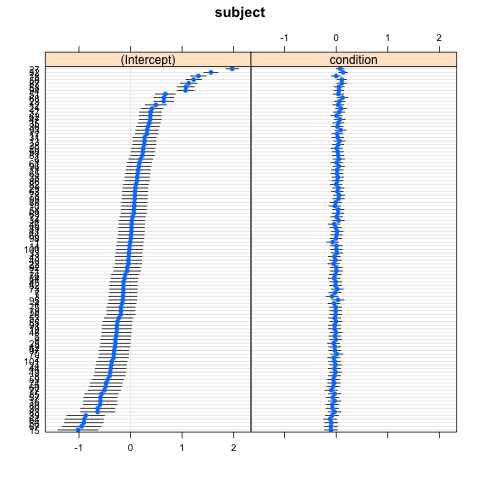

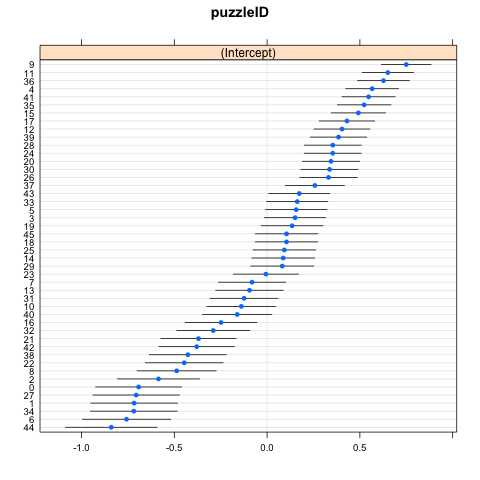

In [62]:
%%R
# theme_set(theme_sjplot())
# sjp.glmer(model2)
# plot_model(model2,type="pred",terms="condition")
# plot_model(model2,type="pred",terms="numFullUndo")
dotplot(ranef(model2,condVar=TRUE)) # dot plot of random effects


In [69]:
%%R
model2_1= glmer(num_loss ~ condition + numFullUndo_center + (1+condition|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

In [70]:
%%R
model3 = glmer(num_loss ~ condition + numFullUndo_center + (1+condition|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

In [71]:
%%R
model4 = glmer(num_loss ~ condition + numFullUndo_center + (1+numFullUndo_center|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



## model comparisons

ref: https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html Testing significance of random effects

In [75]:
%%R 
anova(model0,model1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 | subject)
model1: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 + numFullUndo_center | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0    5 19018 19054 -9503.9    19008                     
model1    7 19021 19071 -9503.3    19007 1.1543  2     0.5615


In [76]:
%%R 
anova(model0,model1_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 | subject)
model1_1: num_loss ~ condition + numFullUndo_center + (1 + numFullUndo_center | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0      5 19018 19054 -9503.9    19008                     
model1_1    7 19022 19072 -9503.8    19008 0.1405  2     0.9321


In [77]:
%%R 
anova(model0,model2)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 | subject)
model2: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model0    5 19018 19054 -9503.9    19008                         
model2    7 19003 19053 -9494.5    18989 18.738  2  8.531e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [78]:
%%R 
anova(model0,model2_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 | subject)
model2_1: num_loss ~ condition + numFullUndo_center + (1 + condition | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance Chisq Df Pr(>Chisq)  
model0      5 19018 19054 -9503.9    19008                      
model2_1    7 19017 19067 -9501.5    19003 4.855  2    0.08826 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [79]:
%%R 
anova(model2,model3)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_center + (1 | puzzleID) + (1 + condition | subject)
model3: num_loss ~ condition + numFullUndo_center + (1 + condition | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model2    7 19003 19053 -9494.5    18989                       
model3    9 19002 19066 -9492.0    18984 5.0347  2    0.08067 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# GLMM with numFullUndo_center0

## R models

In [95]:
%%R
model0 = glmer(num_loss ~ condition + numFullUndo_center0 + (1|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

In [97]:
%%R
model1 = glmer(num_loss ~ condition + numFullUndo_center0 + (1|puzzleID) + (1+numFullUndo_center0|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



In [98]:
%%R
model1_1 = glmer(num_loss ~ condition + numFullUndo_center0 + (1 +numFullUndo_center0 |puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



In [104]:
%%R
model2 = glmer(num_loss ~ condition + numFullUndo_center0 + (1|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

summary(model2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) +  
    (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19003.5  19053.5  -9494.8  18989.5     9285 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9447 -0.6501 -0.3375  0.4722  8.9398 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.277139 0.52644      
          condition   0.006349 0.07968  0.56
 puzzleID (Intercept) 0.196283 0.44304      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.47575    0.08496  -5.599 2.15e-08 ***
condition           -0.12699    0.01550  -8.193 2.54e-16 ***
numFullUndo_center0  0.06583    0.02599   2.533   0.0113 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.

In [100]:
%%R
model2_1= glmer(num_loss ~ condition + numFullUndo_center0 + (1+condition|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

In [101]:
%%R
model3 = glmer(num_loss ~ condition + numFullUndo_center0 + (1+condition|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

In [102]:
%%R
model4 = glmer(num_loss ~ condition + numFullUndo_center0 + (1+numFullUndo_center0|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

## model comparisons

In [105]:
%%R
anova(model0, model1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 | subject)
model1: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 + numFullUndo_center0 | subject)
       npar   AIC   BIC  logLik deviance Chisq Df Pr(>Chisq)
model0    5 19018 19054 -9504.1    19008                    
model1    7 19022 19072 -9504.0    19008 0.253  2     0.8812


In [106]:
%%R
anova(model0, model1_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 | subject)
model1_1: num_loss ~ condition + numFullUndo_center0 + (1 + numFullUndo_center0 | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0      5 19018 19054 -9504.1    19008                     
model1_1    7 19020 19070 -9502.8    19006 2.6063  2     0.2717


In [107]:
%%R
anova(model0, model2_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 | subject)
model2_1: num_loss ~ condition + numFullUndo_center0 + (1 + condition | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model0      5 19018 19054 -9504.1    19008                       
model2_1    7 19017 19067 -9501.7    19003 4.7267  2     0.0941 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [108]:
%%R
anova(model0, model2)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 | subject)
model2: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model0    5 19018 19054 -9504.1    19008                         
model2    7 19004 19054 -9494.8    18990 18.614  2  9.077e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [109]:
%%R
anova(model2, model3)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 + condition | subject)
model3: num_loss ~ condition + numFullUndo_center0 + (1 + condition | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model2    7 19004 19054 -9494.8    18990                       
model3    9 19003 19067 -9492.3    18985 4.8944  2    0.08654 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [110]:
%%R
anova(model2, model4)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_center0 + (1 | puzzleID) + (1 + condition | subject)
model4: num_loss ~ condition + numFullUndo_center0 + (1 + numFullUndo_center0 | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model2    7 19004 19054 -9494.8    18990                     
model4    9 19004 19069 -9493.2    18986 3.1343  2     0.2086


# GLMM with numFullUndo_factor

## R models

In [12]:
%%R
# this case 
model0 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

In [13]:
%%R
model1 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1+numFullUndo_factor|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



In [14]:
%%R
model1_1 = glmer(num_loss ~ condition + numFullUndo_factor + (1 +numFullUndo_factor |puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

R[write to console]: boundary (singular) fit: see ?isSingular



In [15]:
%%R
model2 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

summary(model2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) +  
    (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19008.3  19065.4  -9496.1  18992.3     9284 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9297 -0.6512 -0.3374  0.4753  8.4416 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.275713 0.52508      
          condition   0.004748 0.06891  0.60
 puzzleID (Intercept) 0.196575 0.44337      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.46428    0.08526  -5.445 5.17e-08 ***
condition           -0.11512    0.01689  -6.816 9.39e-12 ***
numFullUndo_factor1 -0.09069    0.05159  -1.758   0.0788 .  
numFullUndo_factor2 -0.02845    0.06974  -0.408   0.6833

In [16]:
%%R
model2_1= glmer(num_loss ~ condition + numFullUndo_factor + (1+condition|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())

In [17]:
%%R
model3 = glmer(num_loss ~ condition + numFullUndo_factor + (1+condition|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

In [25]:
%%R
model4 = glmer(num_loss ~ condition + numFullUndo_factor + (1+numFullUndo_factor|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())

In [141]:
%%R
summary(model4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_factor + (1 + numFullUndo |  
    puzzleID) + (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19006.1  19077.5  -9493.1  18986.1     9282 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9197 -0.6530 -0.3234  0.4673  8.8272 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.276992 0.52630      
          condition   0.004992 0.07065  0.61
 puzzleID (Intercept) 0.188895 0.43462      
          numFullUndo 0.001776 0.04215  1.00
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.45737    0.08400  -5.445 5.19e-08 ***
condition           -0.11619    0.01698  -6.842 7.80e-12 ***
numFullUndo_factor1 -0.10937    0.05243  -2.086    0.037 *

In [142]:
%%R
model.matrix(model4)

     (Intercept) condition numFullUndo_factor1 numFullUndo_factor2
0              1         1                   1                   0
1              1         1                   0                   1
2              1         1                   0                   0
3              1         1                   0                   0
4              1         1                   0                   0
5              1         1                   0                   0
6              1         1                   0                   1
7              1         1                   1                   0
8              1         1                   0                   0
9              1         1                   0                   1
10             1         1                   0                   0
11             1         1                   0                   0
12             1         1                   0                   0
13             1         1                   0                

243            1         1                   0                   1
244            1         1                   0                   1
245            1         1                   0                   1
246            1         1                   0                   1
247            1         1                   0                   1
248            1         1                   0                   1
249            1         1                   0                   0
250            1         1                   0                   0
251            1         1                   0                   1
252            1         1                   1                   0
253            1        -1                   0                   0
254            1        -1                   0                   0
255            1        -1                   0                   0
256            1        -1                   0                   0
257            1        -1                   0                

487            1        -1                   0                   0
488            1        -1                   0                   0
489            1        -1                   0                   0
490            1        -1                   0                   0
491            1        -1                   0                   0
492            1        -1                   0                   0
493            1        -1                   0                   0
494            1        -1                   0                   0
495            1        -1                   0                   0
496            1        -1                   0                   0
497            1        -1                   0                   0
498            1        -1                   0                   0
499            1        -1                   0                   0
500            1        -1                   0                   0
501            1        -1                   0                

731            1        -1                   0                   0
732            1        -1                   0                   0
733            1        -1                   0                   0
734            1        -1                   0                   0
735            1        -1                   0                   0
736            1        -1                   0                   0
737            1        -1                   0                   0
738            1        -1                   0                   0
739            1        -1                   0                   0
740            1        -1                   0                   0
741            1        -1                   0                   0
742            1        -1                   0                   0
743            1        -1                   0                   0
744            1        -1                   0                   0
745            1        -1                   0                

975            1        -1                   0                   0
976            1        -1                   0                   0
977            1        -1                   0                   0
978            1        -1                   0                   0
979            1        -1                   0                   0
980            1        -1                   0                   0
981            1        -1                   0                   0
982            1        -1                   0                   0
983            1        -1                   0                   0
984            1        -1                   0                   0
985            1        -1                   0                   0
986            1        -1                   0                   0
987            1        -1                   0                   0
988            1        -1                   0                   0
989            1         1                   0                

1474           1         1                   0                   0
1475           1         1                   0                   0
1476           1         1                   0                   0
1477           1         1                   0                   0
1478           1         1                   0                   0
1479           1         1                   0                   0
1480           1         1                   0                   0
1481           1         1                   0                   0
1482           1         1                   0                   0
1483           1         1                   0                   0
1484           1         1                   0                   0
1485           1         1                   0                   0
1486           1         1                   0                   0
1487           1         1                   0                   0
1488           1         1                   0                

1880           1         1                   0                   0
1881           1         1                   0                   0
1882                   1
2194           1         1                   0                   1
2195           1         1                   0                   1
2196           1         1                   1                   0
2197           1         1                   0                   0
2198           1         1                   0                   0
2199           1         1                   0                   1
2200           1         1                   0                   1
2201           1         1                   0                   1
2202           1         1                   0                   0
2203           1         1                   0                   0
2204           1         1                   1                   0
2205           1         1                   0                   0
2206           1         1           

2743           1        -1                   0                   0
2744           1        -1                   0                   0
2745           1        -1                   0                   0
2746           1        -1                   0                   0
2747           1        -1                   0                   0
2748           1        -1                   0                   0
2749           1        -1                   0                   0
2750           1        -1                   0                   0
2751           1        -1                   0                   0
2752           1        -1                   0                   0
2753           1        -1                   0                   0
2754           1        -1                   0                   0
2755           1        -1                   0                   0
2756           1        -1                   0                   0
2757           1        -1                   0                

3269           1        -1                   0                   0
3270           1        -1                   0                   0
3271           1        -1                   0                   0
3272           1        -1                   0                   0
3273           1        -1                   0                   0
3274           1        -1                   0                   0
3275           1        -1                   0                   0
3276           1        -1                   0                   0
3277           1        -1                   0                   0
3278           1        -1                   0                   0
3279           1        -1                   0                   0
3280           1        -1                   0                   0
3281           1        -1                   0                   0
3282           1        -1                   0                   0
3283           1        -1                   0                

3969           1         1                   0                   0
3970           1         1                   0                   0
3971           1         1                   0                   0
3972           1         1                   0                   0
3973           1         1                   0                   0
3974           1         1                   0                   0
3975           1         1                   0                   0
3976           1         1                   0                   0
3977           1         1                   0                   1
3978           1         1                   0                   1
3979           1        -1                   0                   0
3980           1        -1                   0                   0
3981           1        -1                   0                   0
3982           1        -1                   0                   0
3983           1        -1                   0                

4527           1        -1                   0                   0
4528           1        -1                   0                   0
4529           1        -1                   0                   0
4530           1        -1                   0                   0
4531           1         1                   0                   0
4532           1         1                   0                   0
4533           1         1                   0                   0
4534           1         1                   0                   0
4535           1         1                   0                   0
4536           1         1                   0                   0
4537           1         1                   0                   0
4538           1         1                   0                   0
4539           1         1                   0                   0
4540           1         1                   0                   0
4541           1         1                   0                

5099           1        -1                   0                   0
5100           1        -1                   0                   0
5101           1        -1                   0                   0
5102           1        -1                   0                   0
5103           1        -1                   0                   0
5104           1        -1                   0                   0
5105           1        -1                   0                   0
5106           1        -1                   0                   0
5107           1        -1                   0                   0
5108           1        -1                   0                   0
5109           1        -1                   0                   0
5110           1        -1                   0                   0
5111           1        -1                   0                   0
5112           1        -1                   0                   0
5113           1        -1                   0                

5814           1         1                   0                   0
5815           1         1                   0                   1
5816           1         1                   0                   0
5817           1         1                   0                   0
5818           1         1                   0                   1
5819           1        -1                   0                   0
5820           1        -1                   0                   0
5821           1        -1                   0                   0
5822           1        -1                   0                   0
5823           1        -1                   0                   0
5824           1        -1                   0                   0
5825           1        -1                   0                   0
5826           1        -1                   0                   0
5827           1        -1                   0                   0
5828           1        -1                   0                

6502           1         1                   0                   0
6503           1         1                   0                   0
6504           1         1                   0                   0
6505           1         1                   0                   0
6506           1         1                   1                   0
6507           1         1                   0                   0
6508           1         1                   0                   0
6509           1        -1                   0                   0
6510           1        -1                   0                   0
6511           1        -1                   0                   0
6512           1        -1                   0                   0
6513           1        -1                   0                   0
6514           1        -1                   0                   0
6515           1        -1                   0                   0
6516           1        -1                   0                

7083           1        -1                   0                   0
7084           1        -1                   0                   0
7085           1        -1                   0                   0
7086           1        -1                   0                   0
7087           1        -1                   0                   0
7088           1        -1                   0                   0
7089           1        -1                   0                   0
7090           1        -1                   0                   0
7091           1        -1                   0                   0
7092           1        -1                   0                   0
7093           1        -1                   0                   0
7094           1        -1                   0                   0
7095           1        -1                   0                   0
7096           1        -1                   0                   0
7097           1        -1                   0                

7626           1         1                   0                   0
7627           1         1                   0                   1
7628           1         1                   0                   1
7629           1         1                   0                   0
7630           1         1                   0                   0
7631           1         1                   0                   0
7632           1         1                   0                   0
7633           1         1                   0                   1
7634           1         1                   0                   0
7635           1         1                   0                   0         1                   0                   0
7804           1         1                   0                   0
7805           1         1                   1                   0
7806           1         1                   0                   1
7807           1         1                   0                   0
7808        

8321           1        -1                   0                   0
8322           1        -1                   0                   0
8323           1        -1                   0                   0
8324           1        -1                   0                   0
8325           1        -1                   0                   0
8326           1        -1                   0                   0
8327           1        -1                   0                   0
8328           1        -1                   0                   0
8329           1        -1                   0                   0
8330           1        -1                   0                   0
8331           1        -1                   0                   0
8332           1        -1                   0                   0
8333           1        -1                   0                   0
8334           1        -1                   0                   0
8335           1        -1                   0                

8709           1        -1                   0                   0
8710           1        -1                   0                   0
8711           1        -1                   0                   0
8712           1        -1                   0                   0
8713           1        -1                   0                   0
8714           1        -1                   0                   0
8715           1        -1                   0                   0
8716           1        -1                   0                   0
8717           1         1                   0                   0
8718           1         1                   0                   0
8719           1         1                   0                   0
8720           1         1                   0                   0
8721           1         1                   0                   0
8722           1         1                   0                   0
8723           1         1                   0                

## model comparisons

In [19]:
%%R
anova(model0, model1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model1: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + numFullUndo_factor | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0    6 19019 19062 -9503.7    19007                     
model1   11 19026 19105 -9502.2    19004 3.0053  5     0.6992


In [20]:
%%R
anova(model0, model1_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model1_1: num_loss ~ condition + numFullUndo_factor + (1 + numFullUndo_factor | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model0      6 19019 19062 -9503.7    19007                       
model1_1   11 19015 19094 -9496.6    18993 14.117  5    0.01488 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
%%R
anova(model0, model2_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model2_1: num_loss ~ condition + numFullUndo_factor + (1 + condition | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model0      6 19019 19062 -9503.7    19007                       
model2_1    8 19019 19076 -9501.4    19003 4.6121  2    0.09965 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [22]:
%%R
anova(model0, model2)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model2: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model0    6 19019 19062 -9503.7    19007                         
model2    8 19008 19065 -9496.1    18992 15.022  2   0.000547 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [23]:
%%R
anova(model2, model3)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + condition | subject)
model3: num_loss ~ condition + numFullUndo_factor + (1 + condition | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model2    8 19008 19065 -9496.1    18992                       
model3   10 19008 19079 -9493.8    18988 4.7861  2    0.09135 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [26]:
%%R
anova(model2, model4)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + condition | subject)
model4: num_loss ~ condition + numFullUndo_factor + (1 + numFullUndo_factor | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model2    8 19008 19065 -9496.1    18992                       
model4   13 19004 19097 -9489.1    18978 14.088  5    0.01506 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# what about factorized numFullundo & condition

In [24]:
condition = (np.array(data_puzzle_level.condition)-0.5)*2
subject = np.array(data_puzzle_level.subjects)
puzzleID = np.array(data_puzzle_level.puzzleID)
numUndo = np.array(data_puzzle_level.numUNDO)
mas = np.array(data_puzzle_level.mas)
num_loss = np.array(data_puzzle_level.mas) - np.array(data_puzzle_level.numCities)
numFullUndo = np.array(data_puzzle_level.numFullUndo)
# numFullUndo = np.sign(numFullUndo)

dat = pd.DataFrame({'subject':subject, 'condition':condition,'mas':mas,
                    'num_loss':num_loss,'puzzleID':puzzleID,'numUndo':numUndo,
                   'numFullUndo':numFullUndo, 'numFullUndo_factor':numFullUndo})



# error correction
dat.mas[dat[dat.num_loss == -1 ].index] = 9
num_loss = np.array(dat.mas) - np.array(data_puzzle_level.numCities)
dat.num_loss = num_loss

C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
%%R -i dat
# dat$numFullUndo <- factor(dat$numFullUndo)
dat$numFullUndo_factor <- factor(dat$numFullUndo_factor)
dat$subject <- factor(dat$subject)
# dat$condition <- factor(dat$condition)
dat$puzzleID <- factor(dat$puzzleID)

In [26]:
%%R
# this case 
model0 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())
model1 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1+numFullUndo|subject)
               , data=dat,
             family=poisson())
model1_1 = glmer(num_loss ~ condition + numFullUndo_factor + (1 +numFullUndo |puzzleID) + (1|subject)
               , data=dat,
             family=poisson())
model2 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
model2_1= glmer(num_loss ~ condition + numFullUndo_factor + (1+condition|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())
model3 = glmer(num_loss ~ condition + numFullUndo_factor + (1+condition|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
model4 = glmer(num_loss ~ condition + numFullUndo_factor + (1+numFullUndo|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
summary(model2)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) +  
    (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19026.5  19162.1  -9494.2  18988.5     9273 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9319 -0.6510 -0.3331  0.4763  8.5136 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.274949 0.52436      
          condition   0.004772 0.06908  0.60
 puzzleID (Intercept) 0.196142 0.44288      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.46380    0.08516  -5.446 5.15e-08 ***
condition             -0.11495    0.01691  -6.799 1.06e-11 ***
numFullUndo_factor1   -0.09099    0.05157  -1.764   0.0777 .  
numFullUndo_factor2   -0.01723    0.08720  -0.19

R[write to console]: 
Correlation matrix not shown by default, as p = 15 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




optimizer (Nelder_Mead) convergence code: 0 (OK)
Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?



In [33]:
%%R
anova(model0, model1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model1: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + numFullUndo | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0   17 19037 19159 -9501.7    19003                     
model1   19 19039 19175 -9500.6    19001 2.1614  2     0.3394


In [27]:
%%R
anova(model0, model1_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model1_1: num_loss ~ condition + numFullUndo_factor + (1 + numFullUndo | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0     17 19037 19159 -9501.7    19003                     
model1_1   19 19037 19173 -9499.6    18999 4.2615  2     0.1187


In [29]:
%%R
anova(model0, model2_1)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model2_1: num_loss ~ condition + numFullUndo_factor + (1 + condition | puzzleID) + (1 | subject)
         npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0     17 19037 19159 -9501.7    19003                     
model2_1   19 19037 19173 -9499.5    18999 4.4665  2     0.1072


In [28]:
%%R
anova(model0, model2)

Data: dat
Models:
model0: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 | subject)
model2: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model0   17 19037 19159 -9501.7    19003                         
model2   19 19027 19162 -9494.2    18989 14.879  2  0.0005876 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [30]:
%%R
anova(model2, model3)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + condition | subject)
model3: num_loss ~ condition + numFullUndo_factor + (1 + condition | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model2   19 19027 19162 -9494.2    18989                       
model3   21 19026 19176 -9491.9    18984 4.6272  2    0.09891 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [31]:
%%R
anova(model2, model4)

Data: dat
Models:
model2: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) + (1 + condition | subject)
model4: num_loss ~ condition + numFullUndo_factor + (1 + numFullUndo | puzzleID) + (1 + condition | subject)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)  
model2   19 19027 19162 -9494.2    18989                       
model4   21 19026 19176 -9491.9    18984 4.7359  2    0.09367 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [32]:
%%R
summary(model4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_factor + (1 + numFullUndo |  
    puzzleID) + (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19025.8  19175.6  -9491.9  18983.8     9271 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9232 -0.6531 -0.3216  0.4688  8.8676 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.275463 0.52485      
          condition   0.004842 0.06959  0.60
 puzzleID (Intercept) 0.188642 0.43433      
          numFullUndo 0.001806 0.04250  1.00
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.460875   0.084081  -5.481 4.22e-08 ***
condition             -0.115475   0.015348  -7.524 5.32e-14 ***
numFullUndo_factor1   -0.110582   0.050320  -2.19

R[write to console]: 
Correlation matrix not shown by default, as p = 15 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




optimizer (Nelder_Mead) convergence code: 0 (OK)
unable to evaluate scaled gradient
Model failed to converge: degenerate  Hessian with 1 negative eigenvalues



In [35]:
%%R
model.matrix(model4)

     (Intercept) condition numFullUndo_factor1 numFullUndo_factor2
0              1         1                   1                   0
1              1         1                   0                   1
2              1         1                   0                   0
3              1         1                   0                   0
4              1         1                   0                   0
5              1         1                   0                   0
6              1         1                   0                   1
7              1         1                   1                   0
8              1         1                   0                   0
9              1         1                   0                   1
10             1         1                   0                   0
11             1         1                   0                   0
12             1         1                   0                   0
13             1         1                   0                

243            1         1                   0                   0
244            1         1                   0                   0
245            1         1                   0                   0
246            1         1                   0                   1
247            1         1                   0                   0
248            1         1                   0                   0
249            1         1                   0                   0
250            1         1                   0                   0
251            1         1                   0                   1
252            1         1                   1                   0
253            1        -1                   0                   0
254            1        -1                   0                   0
255            1        -1                   0                   0
256            1        -1                   0                   0
257            1        -1                   0                

487            1        -1                   0                   0
488            1        -1                   0                   0
489            1        -1                   0                   0
490            1        -1                   0                   0
491            1        -1                   0                   0
492            1        -1                   0                   0
493            1        -1                   0                   0
494            1        -1                   0                   0
495            1        -1                   0                   0
496            1        -1                   0                   0
497            1        -1                   0                   0
498            1        -1                   0                   0
499            1        -1                   0                   0
500            1        -1                   0                   0
501            1        -1                   0                

731            1        -1                   0                   0
732            1        -1                   0                   0
733            1        -1                   0                   0
734            1        -1                   0                   0
735            1        -1                   0                   0
736            1        -1                   0                   0
737            1        -1                   0                   0
738            1        -1                   0                   0
739            1        -1                   0                   0
740            1        -1                   0                   0
741            1        -1                   0                   0
742            1        -1                   0                   0
743            1        -1                   0                   0
744            1        -1                   0                   0
745            1        -1                   0                

975            1        -1                   0                   0
976            1        -1                   0                   0
977            1        -1                   0                   0
978            1        -1                   0                   0
979            1        -1                   0                   0
980            1        -1                   0                   0
981            1        -1                   0                   0
982            1        -1                   0                   0
983            1        -1                   0                   0
984            1        -1                   0                   0
985            1        -1                   0                   0
986            1        -1                   0                   0
987            1        -1                   0                   0
988            1        -1                   0                   0
989            1         1                   0                

1219           1        -1                   0                   0
1220           1        -1                   0                   0
1221           1        -1                   0                   0
1222           1        -1                   0                   0
1223           1        -1                   0                   0
1224           1        -1                   0                   0
1225           1        -1                   0                   0
1226           1        -1                   0                   0
1227           1        -1                   0                   0
1228           1        -1                   0                   0
1229           1        -1                   0                   0
1230           1        -1                   0                   0
1231           1        -1                   0                   0
1232           1        -1                   0                   0
1233           1        -1                   0                

1463           1        -1                   0                   0
1464           1        -1                   0                   0
1465           1        -1                   0                   0
1466           1        -1                   0                   0
1467           1        -1                   0                   0
1468           1        -1                   0                   0
1469           1        -1                   0                   0
1470           1        -1                   0                   0
1471           1        -1                   0                   0
1472           1         1                   0                   0
1473           1         1                   0                   0
1474           1         1                   0                   0
1475           1         1                   0                   0
1476           1         1                   0                   0
1477           1         1                   0                

1707           1        -1                   0                   0
1708           1        -1                   0                   0
1709           1        -1                   0                   0
1710           1        -1                   0                   0
1711           1        -1                   0                   0
1712           1        -1                   0                   0
1713           1        -1                   0                   0
1714           1        -1                   0                   0
1715           1        -1                   0                   0
1716           1        -1                   0                   0
1717           1        -1                   0                   0
1718           1        -1                   0                   0
1719           1        -1                   0                   0
1720           1        -1                   0                   0
1721           1        -1                   0                

1951           1         1                   0                   0
1952           1         1                   0                   0
1953           1         1                   0                   1
1954           1         1                   0                   0
1955           1        -1                   0                   0
1956           1        -1                   0                   0
1957           1        -1                   0                   0
1958           1        -1                   0                   0
1959           1        -1                   0                   0
1960           1        -1                   0                   0
1961           1        -1                   0                   0
1962           1        -1                   0                   0
1963           1        -1                   0                   0
1964           1        -1                   0                   0
1965           1        -1                   0                

2195           1         1                   0                   0
2196           1         1                   1                   0
2197           1         1                   0                   0
2198           1         1                   0                   0
2199           1         1                   0                   1
2200           1         1                   0                   1
2201           1         1                   0                   0
2202           1         1                   0                   0
2203           1         1                   0                   0
2204           1         1                   1                   0
2205           1         1                   0                   0
2206           1         1                   0                   1
2207           1         1                   0                   0
2208           1        -1                   0                   0
2209           1        -1                   0                

2439           1         1                   0                   0
2440           1         1                   1                   0
2441           1         1                   0                   0
2442           1         1                   1                   0
2443           1         1                   0                   0
2444           1         1                   0                   0
2445           1         1                   0                   0
2446           1         1                   1                   0
2447           1         1                   0                   0
2448           1         1                   0                   0
2449           1         1                   0                   0
2450           1         1                   0                   0
2451           1         1                   1                   0
2452           1         1                   0                   0
2453           1         1                   0                

2683           1        -1                   0                   0
2684           1        -1                   0                   0
2685           1        -1                   0                   0
2686           1        -1                   0                   0
2687           1        -1                   0                   0
2688           1        -1                   0                   0
2689           1        -1                   0                   0
2690           1        -1                   0                   0
2691           1         1                   0                   0
2692           1         1                   0                   0
2693           1         1                   0                   0
2694           1         1                   0                   0
2695           1         1                   1                   0
2696           1         1                   0                   0
2697           1         1                   0                

2927           1         1                   0                   0
2928           1         1                   0                   0
2929           1         1                   0                   0
2930           1         1                   0                   0
2931           1         1                   0                   0
2932           1         1                   0                   0
2933           1         1                   0                   0
2934           1         1                   0                   0
2935           1         1                   0                   0
2936           1         1                   0                   0
2937           1         1                   0                   0
2938           1         1                   0                   0
2939           1         1                   0                   0
2940           1         1                   0                   0
2941           1         1                   0                

3171           1        -1                   0                   0
3172           1        -1                   0                   0
3173           1        -1                   0                   0
3174           1        -1                   0                   0
3175           1        -1                   0                   0
3176           1        -1                   0                   0
3177           1        -1                   0                   0
3178           1        -1                   0                   0
3179           1        -1                   0                   0
3180           1        -1                   0                   0
3181           1        -1                   0                   0
3182           1        -1                   0                   0
3183           1        -1                   0                   0
3184           1        -1                   0                   0
3185           1        -1                   0                

3415           1         1                   0                   0
3416           1         1                   0                   0
3417           1         1                   0                   0
3418           1         1                   1                   0
3419           1         1                   0                   0
3420           1         1                   0                   0
3421           1         1                   0                   0
3422           1         1                   0                   0
3423           1         1                   0                   0
3424           1         1                   0                   0
3425           1         1                   0                   0
3426           1         1                   0                   0
3427           1        -1                   0                   0
3428           1        -1                   0                   0
3429           1        -1                   0                

3659           1        -1                   0                   0
3660           1        -1                   0                   0
3661           1        -1                   0                   0
3662           1        -1                   0                   0
3663           1        -1                   0                   0
3664           1        -1                   0                   0
3665           1        -1                   0                   0
3666           1        -1                   0                   0
3667           1        -1                   0                   0
3668           1        -1                   0                   0
3669           1        -1                   0                   0
3670           1        -1                   0                   0
3671           1        -1                   0                   0
3672           1        -1                   0                   0
3673           1        -1                   0                

3903           1         1                   0                   0
3904           1         1                   0                   0
3905           1         1                   1                   0
3906           1         1                   0                   0
3907           1         1                   1                   0
3908           1         1                   0                   0
3909           1         1                   1                   0
3910           1         1                   0                   0
3911           1         1                   0                   0
3912           1         1                   0                   0
3913           1         1                   0                   0
3914           1         1                   0                   0
3915           1         1                   0                   0
3916           1         1                   1                   0
3917           1         1                   0                

4147           1        -1                   0                   0
4148           1        -1                   0                   0
4149           1        -1                   0                   0
4150           1        -1                   0                   0
4151           1        -1                   0                   0
4152           1        -1                   0                   0
4153           1        -1                   0                   0
4154           1        -1                   0                   0
4155           1        -1                   0                   0
4156           1        -1                   0                   0
4157           1        -1                   0                   0
4158           1        -1                   0                   0
4159           1        -1                   0                   0
4160           1        -1                   0                   0
4161           1        -1                   0                

4391           1         1                   0                   0
4392           1         1                   0                   0
4393           1        -1                   0                   0
4394           1        -1                   0                   0
4395           1        -1                   0                   0
4396           1        -1                   0                   0
4397           1        -1                   0                   0
4398           1        -1                   0                   0
4399           1        -1                   0                   0
4400           1        -1                   0                   0
4401           1        -1                   0                   0
4402           1        -1                   0                   0
4403           1        -1                   0                   0
4404           1        -1                   0                   0
4405           1        -1                   0                

4635           1        -1                   0                   0
4636           1        -1                   0                   0
4637           1        -1                   0                   0
4638           1        -1                   0                   0
4639           1        -1                   0                   0
4640           1        -1                   0                   0
4641           1        -1                   0                   0
4642           1        -1                   0                   0
4643           1        -1                   0                   0
4644           1        -1                   0                   0
4645           1        -1                   0                   0
4646           1        -1                   0                   0
4647           1        -1                   0                   0
4648           1        -1                   0                   0
4649           1        -1                   0                

4879           1         1                   0                   0
4880           1         1                   0                   0
4881           1         1                   0                   0
4882           1         1                   0                   0
4883           1         1                   0                   0
4884           1         1                   0                   0
4885           1         1                   0                   0
4886           1         1                   0                   0
4887           1         1                   0                   0
4888           1         1                   0                   0
4889           1         1                   0                   0
4890           1         1                   0                   0
4891           1         1                   0                   0
4892           1         1                   0                   0
4893           1         1                   0                

5373           1         1                   1                   0
5374           1         1                   0                   0
5375           1         1                   0                   0
5376           1         1                   1                   0
5377           1         1                   0                   0
5378           1         1                   1                   0
5379           1         1                   1                   0
5380           1         1                   0                   0
5381           1         1                   1                   0
5382           1         1                   0                   0
5383           1         1                   0                   0
5384           1         1                   0                   0
5385           1         1                   0                   0
5386           1         1                   0                   1
5387           1         1                   0                

5617           1        -1                   0                   0
5618           1        -1                   0                   0
5619           1        -1                   0                   0
5620           1        -1                   0                   0
5621           1        -1                   0                   0
5622           1        -1                   0                   0
5623           1        -1                   0                   0
5624           1        -1                   0                   0
5625           1        -1                   0                   0
5626           1        -1                   0                   0
5627           1        -1                   0                   0
5628           1        -1                   0                   0
5629           1        -1                   0                   0
5630           1        -1                   0                   0
5631           1        -1                   0                

5861           1        -1                   0                   0
5862           1        -1                   0                   0
5863           1        -1                   0                   0
5864           1        -1                   0                   0
5865           1         1                   0                   0
5866           1         1                   0                   1
5867           1         1                   0                   1
5868           1         1                   1                   0
5869           1         1                   0                   1
5870           1         1                   0                   0
5871           1         1                   0                   0
5872           1         1                   1                   0
5873           1         1                   0                   0
5874           1         1                   1                   0
5875           1         1                   0                

6577           1        -1                   0                   0
6578           1        -1                   0                   0
6579           1        -1                   0                   0
6580           1        -1                   0                   0
6581           1        -1                   0                   0
6582           1        -1                   0                   0
6583           1        -1                   0                   0
6584           1        -1                   0                   0
6585           1        -1                   0                   0
6586           1        -1                   0                   0
6587           1        -1                   0                   0
6588           1        -1                   0                   0
6589           1        -1                   0                   0
6590           1        -1                   0                   0
6591           1        -1                   0                

159                    0                   0                   0
160                    0                   0                   0
161                    0                   0                   0
162                    0                   0                   0
163                    0                   0                   0
164                    1                   0                   0
165                    0                   0                   0
166                    0                   0                   0
167                    0                   0                   0
168                    0                   0                   0
169                    0                   0                   0
170                    1                   0                   0
171                    0                   0                   0
172                    0                   0                   0
173                    0                   0                   0
174                    0 

411                    0                   0                   0
412                    0                   0                   0
413                    0                   0                   0
414                    0                   0                   0
415                    0                   0                   0
416                    0                   0                   0
417                    1                   0                   0
418                    0                   0                   0
419                    0                   0                   0
420                    0                   0                   0
421                    0                   0                   0
422                    0                   0                   0
423                    0                   0                   0
424                    0                   0                   0
425                    0                   0                   0
426                    0 

663                    0                   0                   0
664                    0                   0                   0
665                    0                   0                   0
666                    0                   0                   0
667                    0                   0                   0
668                    0                   0                   0
669                    0                   0                   0
670                    0                   0                   0
671                    0                   0                   0
672                    0                   0                   0
673                    0                   0                   0
674                    0                   0                   0
675                    0                   0                   0
676                    0                   0                   0
677                    0                   0                   0
678                    0 

1555                   0                   0                   0
1556                   0                   0                   0
1557                   0                   0                   0
1558                   0                   0                   0
1559                   0                   0                   0
1560                   0                   0                   0
1561                   0                   0                   0
1562                   0                   0                   0
1563                   0                   0                   0
1564                   0                   0                   0
1565                   0                   0                   0
1566                   0                   0                   0
1567                   0                   0                   0
1568                   0                   0                   0
1569                   0                   0                   0
1570                   0 

1807                   0                   0                   0
1808                   0                   0                   0
1809                   0                   0                   0
1810                   0                   0                   0
1811                   0                   0                   0
1812                   0                   0                   0
1813                   0                   0                   0
1814                   0                   0                   0
1815                   0                   0                   0
1816                   0                   0                   0
1817                   0                   0                   0
1818                   0                   0                   0
1819                   0                   0                   0
1820                   0                   0                   0
1821                   0                   0                   0
1822                   0 

2059                   0                   0                   0
2060                   0                   0                   0
2061                   0                   0                   0
2062                   0                   0                   0
2063                   0                   0                   0
2064                   0                   0                   0
2065                   0                   0                   0
2066                   0                   0                   0
2067                   0                   0                   0
2068                   0                   0                   0
2069                   0                   0                   0
2070                   0                   0                   0
2071                   0                   0                   0
2072                   0                   0                   0
2073                   0                   0                   0
2074                   0 

2311                   0                   0                   0
2312                   0                   0                   0
2313                   0                   0                   0
2314                   0                   0                   0
2315                   0                   0                   0
2316                   0                   0                   0
2317                   0                   0                   0
2318                   0                   0                   0
2319                   0                   0                   0
2320                   0                   0                   0
2321                   0                   0                   0
2322                   0                   0                   0
2323                   0                   0                   0
2324                   0                   0                   0
2325                   0                   0                   0
2326                   0 

3286                   0                   0                   0
3287                   0                   0                   0
3288                   0                   0                   0
3289                   0                   0                   0
3290                   0                   0                   0
3291                   0                   0                   0
3292                   0                   0                   0
3293                   0                   0                   0
3294                   0                   0                   0
3295                   0                   0                   0
3296                   0                   0                   0
3297                   0                   0                   0
3298                   0                   0                   0
3299                   0                   0                   0
3300                   0                   0                   0
3301                   0 

3538                   0                   0                   0
3539                   0                   0                   0
3540                   0                   0                   0
3541                   0                   0                   0
3542                   0                   0                   0
3543                   0                   0                   0
3544                   0                   0                   0
3545                   0                   0                   0
3546                   0                   0                   0
3547                   0                   0                   0
3548                   0                   0                   0
3549                   0                   0                   0
3550                   0                   0                   0
3551                   0                   0                   0
3552                   0                   0                   0
3553                   0 

3790                   0                   0                   0
3791                   0                   0                   0
3792                   0                   0                   0
3793                   0                   0                   0
3794                   0                   0                   0
3795                   0                   0                   0
3796                   0                   0                   0
3797                   0                   0                   0
3798                   0                   0                   0
3799                   0                   0                   0
3800                   0                   0                   0
3801                   0                   0                   0
3802                   0                   0                   0
3803                   0                   0                   0
3804                   0                   0                   0
3805                   0 

4042                   0                   1                   0
4043                   0                   0                   0
4044                   0                   0                   0
4045                   0                   0                   0
4046                   0                   0                   0
4047                   0                   0                   0
4048                   0                   0                   0
4049                   0                   0                   0
4050                   0                   0                   0
4051                   0                   0                   0
4052                   0                   0                   0
4053                   0                   0                   0
4054                   0                   0                   0
4055                   0                   0                   0
4056                   0
4701                   0                   0                   0


4938                   0                   0                   0
4939                   0                   0                   0
4940                   0                   0                   0
4941                   0                   0                   0
4942                   0                   0                   0
4943                   0                   0                   0
4944                   0                   0                   0
4945                   0                   0                   0
4946                   0                   0                   0
4947                   0                   0                   0
4948                   0                   0                   0
4949                   0                   0                   0
4950                   0                   0                   0
4951                   0                   0                   0
4952                   0                   0                   0
4953                   0 

5190                   0                   0                   0
5191                   0                   0                   0
5192                   0                   0                   1
5193                   0                   0                   0
5194                   0                   0                   0
5195                   0                   0                   0
5196                   0                   0                   0
5197                   0                   0                   0
5198                   0                   0                   0
5199                   0                   0                   0
5200                   1                   0                   0
5201                   0                   0                   0
5202                   0                   0                   0
5203                   0                   0                   0
5204                   0                   0                   0
5205                   0 

5442                   0                   0                   0
5443                   0                   0                   0
5444                   0                   0                   0
5445                   0                   0                   0
5446                   0                   0                   0
5447                   0                   0                   0
5448                   0                   0                   0
5449                   0                   0                   0
5450                   0                   0                   0
5451                   1                   0                   0
5452                   0                   0                   0
5453                   0                   0                   0
5454                   0                   1                   0
5455                   0                   0                   0
5456                   0                   0                   0
5457                   0 

5694                   0                   0                   0
5695                   0                   0                   0
5696                   0                   0                   0
5697                   0                   0                   0
5698                   0                   0                   0
5699                   0                   0                   0
5700                   0                   0                   0                   0                   0
6438                   0                   0                   0
6439                   0                   0                   0
6440                   0                   0                   0
6441                   0                   0                   0
6442                   0                   0                   0
6443                   0                   0                   0
6444                   0                   0                   0
6445                   0                   0      

15                     0                   0                   0
16                     0                   0                   0
17                     0                   0                   0
18                     0                   0                   0
19                     0                   0                   0
20                     0                   0                   0
21                     0                   0                   0
22                     0                   0                   0
23                     0                   0                   0
24                     0                   0                   0
25                     0                   0                   0
26                     0                   0                   0
27                     0                   0                   0
28                     0                   0                   0
29                     0                   0                   0
30                     0 

267                    0                   0                   0
268                    0                   0                   0
269                    0                   0                   0
270                    0                   0                   0
271                    0                   0                   0
272                    0                   0                   0
273                    0                   0                   0
274                    0                   0                   0
275                    0                   0                   0
276                    0                   0                   0
277                    0                   0                   0
278                    0                   0                   0
279                    0                   0                   0
280                    0                   0                   0
281                    0                   0                   0
282                    0 

519                    0                   0                   0
520                    0                   0                   0
521                    0                   0                   0
522                    0                   0                   0
523                    0                   0                   0
524                    0                   0                   0
525                    0                   0                   0
526                    0                   0                   0
527                    0                   0                   0
528                    0                   0                   0
529                    0                   0                   0
530                    0                   0                   0
531                    0                   0                   0
532                    0                   0                   0
533                    0                   0                   0
534                    0 

1506                   0                   0                   0
1507                   0                   0                   0
1508                   0                   0                   0
1509                   0                   0                   0
1510                   0                   0                   0
1511                   0                   0                   0
1512                   0                   0                   0
1513                   0                   0                   0
1514                   0                   0                   0
1515                   0                   0                   0
1516                   0                   0                   0
1517                   0                   0                   0
1518                   0                   0                   0
1519                   0                   0                   0
1520                   0                   0                   0
1521                   0 

1758                   0                   0                   0
1759                   0                   0                   0
1760                   0                   0                   0
1761                   0                   0                   0
1762                   0                   0                   0
1763                   0                   0                   0
1764                   0                   0                   0
1765                   0                   0                   0
1766                   0                   0                   0
1767                   0                   0                   0
1768                   0                   0                   0
1769                   0                   0                   0
1770                   0                   0                   0
1771                   0                   0                   0
1772                   0                   0                   0
1773                   0 

2010                   0                   0                   0
2011                   0                   0                   0
2012                   0                   0                   0
2013                   0                   0                   0
2014                   0                   0                   0
2015                   0                   0                   0
2016                   0                   0                   0
2017                   0                   0                   0
2018                   0                   0                   0
2019                   0                   0                   0
2020                   0                   0                   0
2021                   0                   0                   0
2022                   0                   0                   0
2023                   0                   0                   0
2024                   0                   0                   0
2025                   0 

2262                   0                   0                   0
2263                   0                   0                   0
2264                   0                   0                   0
2265                   0                   0                   0
2266                   0                   0                   0
2267                   1                   0                   0
2268                   0                   0                   0
2269                   0                   0                   0
2270                   0                   0                   0
2271                   0                   0                   0
2272                   0                   0                   0
2273                   0                   0                   0
2274                   0                   0                   0
2275                   0                   0                   0
2276                   0                   0                   0
2277                   0 

3163                   0                   0                   0
3164                   0                   0                   0
3165                   0                   0                   0
3166                   0                   0                   0
3167                   0                   0                   0
3168                   0                   0                   0
3169                   0                   0                   0
3170                   0                   0                   0
3171                   0                   0                   0
3172                   0                   0                   0
3173                   0                   0                   0
3174                   0                   0                   0
3175                   0                   0                   0
3176                   0                   0                   0
3177                   0                   0                   0
3178                   0 

3415                   0                   0                   0
3416                   0                   0                   0
3417                   0                   0                   0
3418                   0                   0                   0
3419                   0                   0                   0
3420                   0                   0                   0
3421                   0                   0                   0
3422                   0                   0                   0
3423                   0                   0                   0
3424                   0                   0                   0
3425                   0                   0                   0
3426                   0                   0                   0
3427                   0                   0                   0
3428                   0                   0                   0
3429                   0                   0                   0
3430                   0 

3667                   0                   0                   0
3668                   0                   0                   0
3669                   0                   0                   0
3670                   0                   0                   0
3671                   0                   0                   0
3672                   0                   0                   0
3673                   0                   0                   0
3674                   0                   0                   0
3675                   0                   0                   0
3676                   0                   0                   0
3677                   0                   0                   0
3678                   0                   0                   0
3679                   0                   0                   0
3680                   0                   0                   0
3681                   0                   0                   0
3682                   0 

3919                   0                   0                   0
3920                   0                   0                   0
3921                   0                   0                   0
3922                   0                   0                   0
3923                   0                   0                   0
3924                   0                   0                   0
3925                   0                   0                   0
3926                   0                   0                   0
3927                   0                   0                   0
3928                   0                   0                   0
3929                   0                   0                   0
3930                   0                   0                   0
3931                   0                   0                   0
3932                   0                   0                   0
3933                   0                   0                   0
3934                   0 

4877                   0                   0                   0
4878                   0                   0                   0
4879                   0                   0                   0
4880                   0                   0                   0
4881                   0                   0                   0
4882                   0                   0                   0
4883                   0                   0                   0
4884                   0                   0                   0
4885                   0                   0                   0
4886                   0                   0                   0
4887                   0                   0                   0
4888                   0                   0                   0
4889                   0                   0                   0
4890                   0                   0                   0
4891                   0                   0                   0
4892                   0 

5129                   0                   0                   0
5130                   0                   0                   0
5131                   0                   0                   0
5132                   0                   0                   0
5133                   0                   0                   0
5134                   0                   0                   0
5135                   0                   0                   0
5136                   0                   0                   0
5137                   0                   0                   1
5138                   0                   0                   0
5139                   0                   0                   0
5140                   0                   0                   0
5141                   0                   0                   0
5142                   0                   0                   0
5143                   1                   0                   0
5144                   0 

5381                   0                   0                   0
5382                   0                   0                   0
5383                   0                   0                   0
5384                   0                   0                   0
5385                   0                   0                   0
5386                   0                   0                   0
5387                   0                   0                   0
5388                   0                   0                   0
5389                   0                   0                   0
5390                   0                   0                   0
5391                   0                   0                   0
5392                   0                   0                   0
5393                   0                   0                   0
5394                   0                   0                   0
5395                   0                   0                   0
5396                   0 

5633                   0                   0                   0
5634                   0                   0                   0
5635                   0                   0                   0
5636                   0                   0                   0
5637                   0                   0                   0
5638                   0                   0                   0
5639                   0                   0                   0
5640                   0                   0                   0
5641                   0                   0                   0
5642                   0                   0                   0
5643                   0                   0                   0
5644                   0                   0                   0
5645                   0                   0                   0
5646                   0                   0                   0
5647                   0                   0                   0
5648                   0 

6629                   0                   0                   0
6630                   0                   0                   0
6631                   0                   0                   0
6632                   0                   0                   0
6633                   0                   0                   0
6634                   0                   0                   0
6635                   0                   0                   0
6636                   0                   0                   0
6637                   0                   0                   0
6638                   0                   0                   0
6639                   0                   0                   0
6640                   0                   0                   0
6641                   0                   0                   0
6642                   0                   0                   0
6643                   0                   0                   0
6644                   0 

207                    0                    0                    0
208                    0                    0                    0
209                    0                    0                    0
210                    0                    0                    0
211                    0                    0                    0
212                    0                    0                    0
213                    0                    0                    0
214                    0                    0                    0
215                    0                    0                    0
216                    0                    0                    0
217                    0                    0                    0
218                    0                    0                    0
219                    0                    0                    0
220                    0                    0                    0
221                    0                    0                 

451                    0                    0                    0
452                    0                    0                    0
453                    0                    0                    0
454                    0                    0                    0
455                    0                    0                    0
456                    0                    0                    0
457                    0                    0                    0
458                    0                    0                    0
459                    0                    0                    0
460                    0                    0                    0
461                    0                    0                    0
462                    0                    0                    0
463                    0                    0                    0
464                    0                    0                    0
465                    0                    0                 

1348                   0                    0                    0
1349                   0                    0                    0
1350                   0                    0                    0
1351                   0                    0                    0
1352                   0                    0                    0
1353                   0                    0                    0
1354                   0                    0                    0
1355                   0                    0                    0
1356                   0                    0                    0
1357                   0                    0                    0
1358                   0                    0                    0
1359                   0                    0                    0
1360                   0                    0                    0
1361                   0                    0                    0
1362                   0                    0                 

1592                   0                    0                    0
1593                   0                    0                    0
1594                   0                    0                    0
1595                   0                    0                    0
1596                   0                    0                    0
1597                   0                    0                    0
1598                   0                    0                    0
1599                   0                    0                    0
1600                   0                    0                    0
1601                   0                    0                    0
1602                   0                    0                    0
1603                   0                    0                    0
1604                   0                    0                    0
1605                   0                    0                    0
1606                   0                    0                 

1836                   0                    0                    0
1837                   0                    0                    0
1838                   0                    0                    0
1839                   0                    0                    0
1840                   0                    0                    0
1841                   0                    0                    0
1842                   0                    0                    0
1843                   0                    0                    0
1844                   0                    0                    0
1845                   0                    0                    0
1846                   0                    0                    0
1847                   0                    0                    0
1848                   0                    0                    0
1849                   0                    0                    0
1850                   0                    0                 

2080                   0                    0                    0
2081                   0                    0                    0
2082                   0                    0                    0
2083                   0                    0                    0
2084                   0                    0                    0
2085                   0                    0                    0
2086                   0                    0                    0
2087                   0                    0                    0
2088                   0                    0                    0
2089                   0                    0                    0
2090                   0                    0                    0
2091                   0                    0                    0
2092                   0                    0                    0
2093                   0                    0                    0
2094                   0                    0                 

2324                   0                    0                    0
2325                   0                    0                    0
2326                   0                    0                    0
2327                   0                    0                    0
2328                   0                    0                    0
2329                   0                    0                    0
2330                   0                    0                    0
2331                   0                    0                    0
2332                   0                    0                    0
2333                   0                    0                    0
2334                   0                    0                    0
2335                   0                    0                    0
2336                   0                    0                    0
2337                   0                    0                    0
2338                   0                    0                 

3212                   0                    0                    0
3213                   0                    0                    0
3214                   0                    0                    0
3215                   0                    0                    0
3216                   0                    0                    0
3217                   0                    0                    0
3218                   0                    0                    0
3219                   0                    0                    0
3220                   0                    0                    0
3221                   0                    0                    0
3222                   0                    0                    0
3223                   0                    0                    0
3224                   0                    0                    0
3225                   0                    0                    0
3226                   0                    0                 

3456                   0                    0                    0
3457                   0                    0                    0
3458                   0                    0                    0
3459                   0                    0                    0
3460                   0                    0                    0
3461                   0                    0                    0
3462                   0                    0                    0
3463                   0                    0                    0
3464                   0                    0                    0
3465                   0                    0                    0
3466                   0                    0                    0
3467                   0                    0                    0
3468                   0                    0                    0
3469                   0                    0                    0
3470                   0                    0                 

3700                   0                    0                    0
3701                   0                    0                    0
3702                   0                    0                    0
3703                   0                    0                    0
3704                   0                    0                    0
3705                   0                    0                    0
3706                   0                    0                    0
3707                   0                    0                    0
3708                   0                    0                    0
3709                   0                    0                    0
3710                   0                    0                    0
3711                   0                    0                    0
3712                   0                    0                    0
3713                   0                    0                    0
3714                   0                    0                 

3944                   0                    0                    0
3945                   0                    0                    0
3946                   0                    0                    0
3947                   0                    0                    0
3948                   0                    0                    0
3949                   0                    0                    0
3950                   0                    0                    0
3951                   0                    0                    0
3952                   0                    0                    0
3953                   0                    0                    0
3954                   0                    0                    0
3955                   0                    0                    0
3956                   0                    0                    0
3957                   0                    0                    0
3958                   0                    0                 

4893                   0                    0                    0
4894                   0                    0                    0
4895                   0                    0                    0
4896                   0                    0                    0
4897                   0                    0                    0
4898                   0                    0                    0
4899                   0                    0                    0
4900                   0                    0                    0
4901                   0                    0                    0
4902                   0                    0                    0
4903                   0                    0                    0
4904                   0                    0                    0
4905                   0                    0                    0
4906                   0                    0                    0
4907                   0                    0                 

5137                   0                    0                    0
5138                   0                    0                    0
5139                   0                    0                    0
5140                   0                    0                    0
5141                   0                    0                    0
5142                   0                    0                    0
5143                   0                    0                    0
5144                   0                    0                    0
5145                   0                    0                    0
5146                   0                    0                    0
5147                   0                    0                    0
5148                   0                    0                    0
5149                   0                    0                    0
5150                   0                    0                    0
5151                   0                    0                 

5381                   0                    0                    0
5382                   0                    0                    0
5383                   0                    0                    0
5384                   0                    0                    0
5385                   0                    0                    0
5386                   0                    0                    0
5387                   0                    0                    0
5388                   0                    0                    0
5389                   0                    0                    0
5390                   0                    0                    0
5391                   0                    0                    0
5392                   0                    0                    0
5393                   0                    0                    0
5394                   0                    0                    0
5395                   0                    0                 

6072                   0                    0                    0
6073                   0                    0                    0
6074                   0                    0                    0
6075                   0                    0                    0
6076                   0                    0                    0
6077                   0                    0                    0
6078                   0                    0                    0
6079                   0                    0                    0
6080                   0                    0                    0
6081                   0                    0                    0
6082                   0                    0                    0
6083                   0                    0                    0
6084                   0                    0                    0
6085                   0                    0                    0
6086                   0                    0                 

6316                   0                    0                    0
6317                   0                    0                    0
6318                   0                    0                    0
6319                   0                    0                    0
6320                   0                    0                    0
6321                   0                    0                    0
6322                   0                    0                    0
6323                   0                    0                    0
6324                   0                    0                    0
6325                   0                    0                    0
6326                   0                    0                    0
6327                   0                    0                    0
6328                   0                    0                    0
6329                   0                    0                    0
6330                   0                    0                 

6560                   0                    0                    0
6561                   0                    0                    0
6562                   0                    0                    0
6563                   0                    0                    0
6564                   0                    0                    0
6565                   0                    0                    0
6566                   0                    0                    0
6567                   0                    0                    0
6568                   0                    0                    0
6569                   0                    0                    0
6570                   0                    0                    0
6571                   0                    0                    0
6572                   0                    0                    0
6573                   0                    0                    0
6574                   0                    0                 

196                     0                    0
197                     0                    0
198                     0                    0
199                     0                    0
200                     0                    0
201                     0                    0
202                     0                    0
203                     0                    0
204                     0                    0
205                     0                    0
206                     0                    0
207                     0                    0
208                     0                    0
209                     0                    0
210                     0                    0
211                     0                    0
212                     0                    0
213                     0                    0
214                     0                    0
215                     0                    0
216                     0                    0
217          

1145                    0                    0
1146                    0                    0
1147                    0                    0
1148                    0                    0
1149                    0                    0
1150                    0                    0
1151                    0                    0
1152                    0                    0
1153                    0                    0
1154                    0                    0
1155                    0                    0
1156                    0                    0
1157                    0                    0
1158                    0                    0
1159                    0                    0
1160                    0                    0
1161                    0                    0
1162                    0                    0
1163                    0                    0
1164                    0                    0
1165                    0                    0
1166         

1493                    0                    0
1494                    0                    0
1495                    0                    0
1496                    0                    0
1497                    0                    0
1498                    0                    0
1499                    0                    0
1500                    0                    0
1501                    0                    0
1502                    0                    0
1503                    0                    0
1504                    0                    0
1505                    0                    0
1506                    0                    0
1507                    0                    0
1508                    0                    0
1509                    0                    0
1510                    0                    0
1511                    0                    0
1512                    0                    0
1513                    0                    0
1514         

1841                    0                    0
1842                    0                    0
1843                    0                    0
1844                    0                    0
1845                    0                    0
1846                    0                    0
1847                    0                    0
1848                    0                    0
1849                    0                    0
1850                    0                    0
1851                    0                    0
1852                    0                    0
1853                    0                    0
1854                    0                    0
1855                    0                    0
1856                    0                    0
1857                    0                    0
1858                    0                    0
1859                    0                    0
1860                    0                    0
1861                    0                    0
1862         

2189                    0                    0
2190                    0                    0
2191                    0                    0
2192                    0                    0
2193                    0                    0
2194                    0                    0
2195                    0                    0
2196                    0                    0
2197                    0                    0
2198                    0                    0
2199                    0                    0
2200                    0                    0
2201                    0                    0
2202                    0                    0
2203                    0                    0
2204                    0                    0
2205                    0                    0
2206                    0                    0
2207                    0                    0
2208                    0                    0
2209                    0                    0
2210         

3081                    0                    0
3082                    0                    0
3083                    0                    0
3084                    0                    0
3085                    0                    0
3086                    0                    0
3087                    0                    0
3088                    0                    0
3089                    0                    0
3090                    0                    0
3091                    0                    0
3092                    0                    0
3093                    0                    0
3094                    0                    0
3095                    0                    0
3096                    0                    0
3097                    0                    0
3098                    0                    0
3099                    0                    0
3100                    0                    0
3101                    0                    0
3102         

3429                    0                    0
3430                    0                    0
3431                    0                    0
3432                    0                    0
3433                    0                    0
3434                    0                    0
3435                    0                    0
3436                    0                    0
3437                    0                    0
3438                    0                    0
3439                    0                    0
3440                    0                    0
3441                    0                    0
3442                    0                    0
3443                    0                    0
3444                    0                    0
3445                    0                    0
3446                    0                    0
3447                    0                    0
3448                    0                    0
3449                    0                    0
3450         

3777                    0                    0
3778                    0                    0
3779                    0                    0
3780                    0                    0
3781                    0                    0
3782                    0                    0
3783                    0                    0
3784                    0                    0
3785                    0                    0
3786                    0                    0
3787                    0                    0
3788                    0                    0
3789                    0                    0
3790                    0                    0
3791                    0                    0
3792                    0                    0
3793                    0                    0
3794                    0                    0
3795                    0                    0
3796                    0                    0
3797                    0                    0
3798         

5162                    0                    0
5163                    0                    0
5164                    0                    0
5165                    0                    0
5166                    0                    0
5167                    0                    0
5168                    0                    0
5169                    0                    0
5170                    0                    0
5171                    0                    0
5172                    0                    0
5173                    0                    0
5174                    0                    0
5175                    0                    0
5176                    0                    0
5177                    0                    0
5178                    0                    0
5179                    0                    0
5180                    0                    0
5181                    0                    0
5182                    0                    0
5183         

5510                    0                    0
5511                    0                    0
5512                    0                    0
5513                    0                    0
5514                    0                    0
5515                    0                    0
5516                    0                    0
5517                    0                    0
5518                    0                    0
5519                    0                    0
5520                    0                    0
5521                    0                    0
5522                    0                    0
5523                    0                    0
5524                    0                    0
5525                    0                    0
5526                    0                    0
5527                    0                    0
5528                    0                    0
5529                    0                    0
5530                    0                    0
5531         

5858                    0                    0
5859                    0                    0
5860                    0                    0
5861                    0                    0
5862                    0                    0
5863                    0                    0
5864                    0                    0
5865                    0                    0
5866                    0                    0
5867                    0                    0
5868                    0                    0
5869                    0                    0
5870                    0                    0
5871                    0                    0
5872                    0                    0
5873                    0                    0
5874                    0                    0
5875                    0                    0
5876                    0                    0
5877                    0                    0
5878                    0                    0
5879         

6206                    0                    0
6207                    0                    0
6208                    0                    0
6209                    0                    0
6210                    0                    0
6211                    0                    0
6212                    0                    0
6213                    0                    0
6214                    0                    0
6215                    0                    0
6216                    0                    0
6217                    0                    0
6218                    0                    0
6219                    0                    0
6220                    0                    0
6221                    0                    0
6222                    0                    0
6223                    0                    0
6224                    0                    0
6225                    0                    0
6226                    0                    0
6227         

$subject

$puzzleID



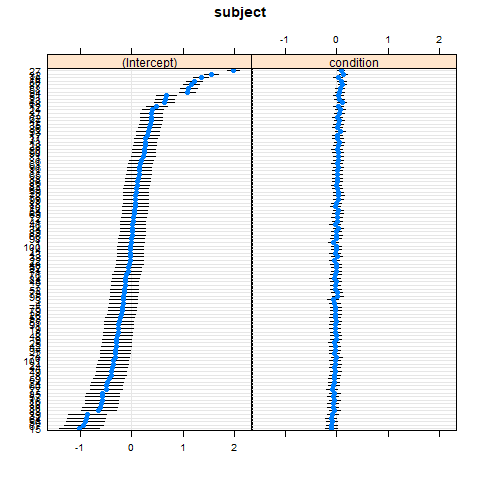

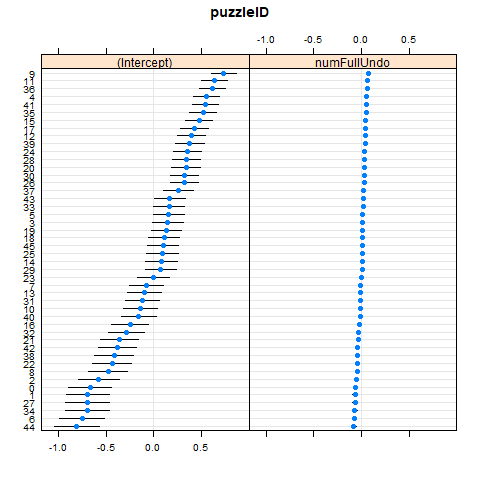

In [37]:
%%R

# theme_set(theme_sjplot())
# sjp.glmer(model2)
# plot_model(model2,type="pred",terms="condition")
# plot_model(model2,type="pred",terms="numFullUndo")
dotplot(ranef(model4,condVar=TRUE))


# -1 1 rather than facto

In [122]:
condition = (np.array(data_puzzle_level.condition)-0.5)*2
subject = np.array(data_puzzle_level.subjects)
puzzleID = np.array(data_puzzle_level.puzzleID)
numUndo = np.array(data_puzzle_level.numUNDO)
mas = np.array(data_puzzle_level.mas)
num_loss = np.array(data_puzzle_level.mas) - np.array(data_puzzle_level.numCities)
numFullUndo = np.array(data_puzzle_level.numFullUndo)
# numFullUndo = np.sign(numFullUndo)

dat = pd.DataFrame({'subject':subject, 'condition':condition,'mas':mas,
                    'num_loss':num_loss,'puzzleID':puzzleID,'numUndo':numUndo,
                   'numFullUndo':numFullUndo, 'numFullUndo_factor':numFullUndo})



# error correction
dat.mas[dat[dat.num_loss == -1 ].index] = 9
num_loss = np.array(dat.mas) - np.array(data_puzzle_level.numCities)
dat.num_loss = num_loss

C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [123]:
dat['numFullUndo_factor'][dat['numFullUndo_factor']==1] = -.5
dat['numFullUndo_factor'][dat['numFullUndo_factor']>=2] = .5

C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
%%R -i dat
# dat$numFullUndo <- factor(dat$numFullUndo)
# dat$numFullUndo_factor <- factor(dat$numFullUndo_factor)
dat$subject <- factor(dat$subject)
# dat$condition <- factor(dat$condition)
dat$puzzleID <- factor(dat$puzzleID)

In [127]:
%%R
# this case 
model0 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())
model1 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1+numFullUndo|subject)
               , data=dat,
             family=poisson())
model1_1 = glmer(num_loss ~ condition + numFullUndo_factor + (1 +numFullUndo |puzzleID) + (1|subject)
               , data=dat,
             family=poisson())
model2 = glmer(num_loss ~ condition + numFullUndo_factor + (1|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
model2_1= glmer(num_loss ~ condition + numFullUndo_factor + (1+condition|puzzleID) + (1|subject)
               , data=dat,
             family=poisson())
model3 = glmer(num_loss ~ condition + numFullUndo_factor + (1+condition|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
model4 = glmer(num_loss ~ condition + numFullUndo_factor + (1+numFullUndo|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
summary(model2)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) +  
    (1 + condition | subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19007.8  19057.7  -9496.9  18993.8     9285 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9395 -0.6508 -0.3371  0.4717  8.4800 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.278778 0.52799      
          condition   0.006124 0.07826  0.58
 puzzleID (Intercept) 0.196240 0.44299      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.47373    0.08506  -5.569 2.56e-08 ***
condition          -0.12484    0.01545  -8.082 6.39e-16 ***
numFullUndo_factor  0.08919    0.07038   1.267    0.205    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1

In [128]:
%%R
model.matrix(model2)

     (Intercept) condition numFullUndo_factor
0              1         1               -0.5
1              1         1                0.5
2              1         1                0.0
3              1         1                0.0
4              1         1                0.0
5              1         1                0.0
6              1         1                0.5
7              1         1               -0.5
8              1         1                0.0
9              1         1                0.5
10             1         1                0.0
11             1         1                0.0
12             1         1                0.0
13             1         1                0.0
14             1         1               -0.5
15             1         1                0.5
16             1         1                0.0
17             1         1                0.5
18             1         1                0.0
19             1         1                0.0
20             1         1        

355            1         1                0.5
356            1         1                0.0
357            1         1                0.5
358            1         1                0.0
359            1         1                0.0
360            1         1                0.0
361            1         1                0.0
362            1         1                0.0
363            1         1               -0.5
364            1         1                0.0
365            1         1                0.0
366            1         1                0.0
367            1         1                0.0
368            1        -1                0.0
369            1        -1                0.0
370            1        -1                0.0
371            1        -1                0.0
372            1        -1                0.0
373            1        -1                0.0
374            1        -1                0.0
375            1        -1                0.0
376            1        -1        

711            1         1                0.0
712            1         1                0.0
713            1        -1                0.0
714            1        -1                0.0
715            1        -1                0.0
716            1        -1                0.0
717            1        -1                0.0
718            1        -1                0.0
719            1        -1                0.0
720            1        -1                0.0
721            1        -1                0.0
722            1        -1                0.0
723            1        -1                0.0
724            1        -1                0.0
725            1        -1                0.0
726            1        -1                0.0
727            1        -1                0.0
728            1        -1                0.0
729            1        -1                0.0
730            1        -1                0.0
731            1        -1                0.0
732            1        -1        

1067           1         1                0.0
1068           1         1                0.0
1069           1         1                0.0
1070           1         1                0.0
1071           1         1                0.0
1072           1         1                0.0
1073           1         1                0.0
1074           1         1                0.0
1075           1         1                0.0
1076           1         1                0.0
1077           1         1                0.0
1078           1         1                0.0
1079           1         1               -0.5
1080           1         1                0.0
1081           1        -1                0.0
1082           1        -1                0.0
1083           1        -1                0.0
1084           1        -1                0.0
1085           1        -1                0.0
1086           1        -1                0.0
1087           1        -1                0.0
1088           1        -1        

1990           1        -1                0.0
1991           1        -1                0.0
1992           1        -1                0.0
1993           1        -1                0.0
1994           1        -1                0.0
1995           1        -1                0.0
1996           1        -1                0.0
1997           1        -1                0.0
1998           1        -1                0.0
1999           1        -1                0.0
2000           1        -1                0.0
2001           1         1               -0.5
2002           1         1               -0.5
2003           1         1                0.0
2004           1         1                0.0
2005           1         1                0.0
2006           1         1                0.0
2007           1         1                0.0
2008           1         1               -0.5
2009           1         1                0.0
2010           1         1                0.0
2011           1         1        

2944           1         1                0.0
2945           1         1                0.5
2946           1         1                0.0
2947           1         1               -0.5
2948           1         1                0.0
2949           1         1                0.0
2950           1         1                0.0
2951           1         1                0.0
2952           1         1                0.0
2953           1         1               -0.5
2954           1         1               -0.5
2955           1         1                0.0
2956           1         1                0.0
2957           1         1                0.0
2958           1         1                0.0
2959           1         1                0.0
2960           1         1                0.0
2961           1         1                0.0
2962           1         1               -0.5
2963           1         1                0.0
2964           1         1               -0.5
2965           1         1        

3927           1         1                0.0
3928           1         1                0.0
3929           1         1                0.0
3930           1         1               -0.5
3931           1         1                0.0
3932           1         1                0.0
3933           1        -1                0.0
3934           1        -1                0.0
3935           1        -1                0.0
3936           1        -1                0.0
3937           1        -1                0.0
3938           1        -1                0.0
3939           1        -1                0.0
3940           1        -1                0.0
3941           1        -1                0.0
3942           1        -1                0.0
3943           1        -1                0.0
3944           1        -1                0.0
3945           1        -1                0.0
3946           1        -1                0.0
3947           1        -1                0.0
3948           1        -1        

4703           1         1                0.0
4704           1         1               -0.5
4705           1         1                0.0
4706           1         1                0.0
4707           1         1                0.0
4708           1         1                0.0
4709           1         1                0.0
4710           1         1                0.0
4711           1         1                0.0
4712           1         1                0.0
4713           1         1                0.0
4714           1         1                0.0
4932           1        -1                0.0
4933           1        -1                0.0
4934           1        -1                0.0
4935           1        -1                0.0
4936           1        -1                0.0
4937           1        -1                0.0
4938           1        -1                0.0
4939           1        -1                0.0
4940           1        -1                0.0
4941           1        -1        

5728           1        -1                0.0
5729           1        -1                0.0
5730           1        -1                0.0
5731           1        -1                0.0
5732           1        -1                0.0
5733           1        -1                0.0
5734           1        -1                0.0
5735           1        -1                0.0
5736           1        -1                0.0
5737           1        -1                0.0
5738           1        -1                0.0
5739           1        -1                0.0
5740           1        -1                0.0
5741           1        -1                0.0
5742           1        -1                0.0
5743           1        -1                0.0
5744           1        -1                0.0
5745           1        -1                0.0
5746           1        -1                0.0
5747           1        -1                0.0
5748           1        -1                0.0
5749           1        -1        

6702           1         1                0.0
6703           1         1                0.0
6704           1         1                0.0
6705           1         1                0.0
6706           1         1                0.0
6707           1         1                0.0
6708           1         1                0.0
6709           1         1                0.0
6710           1         1                0.0
6711           1         1                0.0
6712           1         1                0.0
6713           1         1                0.0
6714           1         1                0.0
6715           1         1                0.0
6716           1        -1                0.0
6717           1        -1                0.0
6718           1        -1                0.0
6719           1        -1                0.0
6720           1        -1                0.0
6721           1        -1                0.0
6722           1        -1                0.0
6723           1        -1        

7606           1        -1                0.0
7607           1        -1                0.0
7608           1        -1                0.0
7609           1        -1                0.0
7610           1        -1                0.0
7611           1        -1                0.0
7612           1        -1                0.0
7613           1         1               -0.5
7614           1         1                0.0
7615           1         1                0.0
7616           1         1                0.0
7617           1         1                0.0
7618           1         1                0.0
7619           1         1               -0.5
7620           1         1                0.0
7621           1         1                0.0
7622           1         1                0.0
7623           1         1                0.0
7624           1         1               -0.5
7625           1         1               -0.5
7626           1         1                0.0
7627           1         1        

8727           1         1                0.0
8728           1         1                0.0
8729           1         1                0.0
8730           1         1                0.0
8731           1         1                0.0
8732           1         1                0.0
8733           1         1                0.0
8734           1         1                0.0
8735           1         1                0.0
8736           1         1                0.0
8737           1         1                0.0
8738           1         1                0.0
8739           1         1                0.0
8740           1         1                0.0
8741           1         1                0.0
8742           1         1                0.0
8743           1         1                0.0
8744           1         1                0.0
8745           1         1                0.0
8746           1         1                0.0
8747           1         1                0.0
8748           1         1        

In [130]:
%%R
model1

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_loss ~ condition + numFullUndo_factor + (1 | puzzleID) +  
    (1 + numFullUndo | subject)
   Data: dat
      AIC       BIC    logLik  deviance  df.resid 
19024.858 19074.817 -9505.429 19010.858      9285 
Random effects:
 Groups   Name        Std.Dev. Corr
 subject  (Intercept) 0.51363      
          numFullUndo 0.02095  1.00
 puzzleID (Intercept) 0.44333      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46
Fixed Effects:
       (Intercept)           condition  numFullUndo_factor  
          -0.45569            -0.09909             0.09010  
optimizer (Nelder_Mead) convergence code: 0 (OK) ; 0 optimizer warnings; 1 lme4 warnings 


# ----

In [41]:
condition = (np.array(data_puzzle_level.condition)-0.5)*2
subject = np.array(data_puzzle_level.subjects)
puzzleID = np.array(data_puzzle_level.puzzleID)
numUndo = np.array(data_puzzle_level.numUNDO)
mas = np.array(data_puzzle_level.mas)
num_loss = np.array(data_puzzle_level.mas) - np.array(data_puzzle_level.numCities)
numFullUndo = np.array(data_puzzle_level.numFullUndo)
# numFullUndo = np.sign(numFullUndo)

dat = pd.DataFrame({'subject':subject, 'condition':condition,'mas':mas,
                    'num_loss':num_loss,'puzzleID':puzzleID,'numUndo':numUndo,
                   'numFullUndo':numFullUndo, 'numFullUndo_factor':numFullUndo})



# error correction
dat.mas[dat[dat.num_loss == -1 ].index] = 9
num_loss = np.array(dat.mas) - np.array(data_puzzle_level.numCities)
dat.num_loss = num_loss

C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [42]:
dat['numFullUndo'][dat[dat['numFullUndo']<=1].index] = -1
dat['numFullUndo'][dat[dat['numFullUndo']==2].index] = 0
dat['numFullUndo'][dat[dat['numFullUndo']>2].index] = 1

C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [33]:
dat['numFullUndo'][dat[dat['numFullUndo']==0].index] = -1
dat['numFullUndo'][dat[dat['numFullUndo']==1].index] = 0
dat['numFullUndo'][dat[dat['numFullUndo']>1].index] = 1

C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\dongj\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
np.unique(dat['numFullUndo'])

array([-1,  0,  1], dtype=int64)

In [44]:
%%R -i dat

# dat$numFullUndo <- factor(dat$numFullUndo)
dat$numFullUndo_factor <- factor(dat$numFullUndo_factor)
dat$subject <- factor(dat$subject)
# dat$condition <- factor(dat$condition)
dat$puzzleID <- factor(dat$puzzleID)

In [45]:
%%R

model1 = glmer(num_loss ~ condition + numFullUndo +  (1|puzzleID) + (1+condition|subject)
               , data=dat,
             family=poisson())
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
num_loss ~ condition + numFullUndo + (1 | puzzleID) + (1 + condition |  
    subject)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
 19009.4  19059.3  -9497.7  18995.4     9285 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9451 -0.6511 -0.3350  0.4746  8.2496 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.276627 0.52595      
          condition   0.006204 0.07877  0.56
 puzzleID (Intercept) 0.196102 0.44283      
Number of obs: 9292, groups:  subject, 101; puzzleID, 46

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.4743274  0.0934093  -5.078 3.82e-07 ***
condition   -0.1263262  0.0160958  -7.848 4.21e-15 ***
numFullUndo  0.0007654  0.0434437   0.018    0.986    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fix

In [ ]:
%%R

model1 = glmer(num_loss ~ condition + numUndo + (1|subject) + (1|puzzleID) + (0+condition|subject)
               , data=dat,
             family=poisson())
summary(model1)

In [ ]:
%%R

model1 = glmer(num_loss ~ condition + numFullUndo_factor + (1|subject) + (1|puzzleID) + (0+condition|subject)
               , data=dat,
             family=poisson())
summary(model1)

In [ ]:
%%R
model01 = glmer(num_loss ~ condition + numUndo +  (1|puzzleID)
               , data=dat,
             family=poisson())
model02 = glmer(num_loss ~ condition + numUndo +  (1|subject)
               , data=dat,
             family=poisson())
model00 = glmer(num_loss ~ condition + numUndo + (1|subject) + (1|puzzleID)
               , data=dat,
             family=poisson())
model1 = glmer(num_loss ~ condition + numUndo + (1+condition|subject) + (1|puzzleID)
               , data=dat,
             family=poisson())
model2 = glmer(num_loss ~ condition + numUndo + (1|subject) + (1+condition|puzzleID)
               ,  data=dat,
             family=poisson())
model3 = glmer(num_loss ~ condition + numUndo + (1+condition|subject) + (1+condition|puzzleID)
               ,  data=dat,
             family=poisson())
model4 = glmer(num_loss ~ condition + numUndo + (1+numUndo|subject) + (1|puzzleID)
               , data=dat,
             family=poisson())
model5 = glmer(num_loss ~ condition + numUndo + (1|subject) + (1+numUndo|puzzleID)
               ,  data=dat,
            family=poisson())
model6 = glmer(num_loss ~ condition + numUndo + (1+numUndo|subject) + (1+numUndo|puzzleID)
               ,  data=dat,
            family=poisson())
model7 = glmer(num_loss ~ condition + numUndo + (1+condition+numUndo|subject) + (1+numUndo|puzzleID)
               ,  data=dat,
            family=poisson())
model8 = glmer(num_loss ~ condition + numUndo + (1+condition+numUndo|subject) + (1+condition+numUndo|puzzleID)
               ,  data=dat,
            family=poisson())


summary(model8)